Objectiu o problema que es vol resoldre: Tractar de predir on es cometrà un delicte o número de delictes per un any. Classificar delictes per zona?
Predir en quina localització es produirá el crim(carrer,residencia) a través de el tipus de crim, si hi ha arrest, si es domestic etc.
Predir tipus de crim arrel de la localització del crim, arrest,domestic etc.

Llistat de funcions que farem servir per netejar el dataset

In [2]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
import seaborn as sns
from IPython.display import display, HTML

def datasetReplace(ds):
    ds = ds.replace("%", "", regex=True)
    ds = ds.replace(",", "", regex=True)
    return ds

def nullCounter(ds):
    print(ds.isnull().sum())
    print(ds.shape)
    
def printColumnTypes(ds):
    for line in ds.columns:
        print(line, type(ds[line][0]))
    print("-------------------------------------------------------")
    print(ds.shape)
    
# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.set_option('display.max_columns', None)
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
    return dataset

def printColumnValues(ds):
    columns = ds.columns
    for col in columns:
        print(col ," values: ", ds[col].unique())
        print("---------------------------------------------------------------------------------------------")

In [2]:
# Carreguem 4 datasets, més endevant unirem tots i agafarem un nombre X de files per treballar
crimeC2001To2004 = load_dataset("data/Chicago_Crimes_2001_to_2004.csv")

crimeC2005To2007 = load_dataset("data/Chicago_Crimes_2005_to_2007.csv")

crimeC2008To2011 = load_dataset("data/Chicago_Crimes_2008_to_2011.csv")

crimeC2012To2017 = load_dataset("data/Chicago_Crimes_2012_to_2017.csv")

# Fusionem els 4 datasets en un sol

frames = [crimeC2001To2004, crimeC2005To2007, crimeC2008To2011, crimeC2012To2017]

crimeC = pd.concat(frames)

display(HTML(crimeC[50:70].to_html()))
nullCounter(crimeC)

print("Dimensionalitat de la BBDD:", crimeC.shape)

C:\Users\adria\AppData\Local\Temp\ipykernel_17880\1449035986.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
b'Skipping line 1513591: expected 23 fields, saw 24\n'
C:\Users\adria\AppData\Local\Temp\ipykernel_17880\1449035986.py:31: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
C:\Users\adria\AppData\Local\Temp\ipykernel_17880\1449035986.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
b'Skipping line 533719: expected 23 fields, saw 24\n'
C:\Users\adria\AppData\Local\Temp\ipykernel_17880\1449035986.py:31: Fut

Unnamed: 0                   0
ID                           0
Case Number                  7
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description      1990
Arrest                       0
Domestic                     0
Beat                         0
District                    91
Ward                    700224
Community Area          702091
FBI Code                     0
X Coordinate            105573
Y Coordinate            105573
Year                         0
Updated On                   0
Latitude                105573
Longitude               105574
Location                105574
dtype: int64
(7941282, 23)
Dimensionalitat de la BBDD: (7941282, 23)


Explicació dels atributs de la Base de dades:
- ID: Identificador únic per al registre.
- Case Number: Identificador únic per a un incident.
- Date: Data en la que va ocorrer el incident. A vegades pot set una estimació.
- Block: Direcció parcial(suposem per motius de privacitat,etc.) del lloc del incident.
- IUCR: Illinois Uniform Reporting Code. Está relacionat deirectament amb Primary Type i Description.
- Primary Type: Descripció principal del codi IUCR.
- Description: Descripció secundària del codi IUCR. Subcategoria de Primary Type.
- Location Description: Descripció de l'ubicació on va ocorrer l'incident.
- Arrest: Booleà que indica si va haver-hi un arrest o no.
- Domestic: Booleà que indica si l'incident està relacionat amb violència domèstica.
- Beat: Indica el beat(barrio?) on va ocorrer l'incident. Un beat és l'àrea geogràfica policial més petita.
- District: Indica el districte policial on va ocorrer l'incident.
- Ward: Districte del ajuntament on el incident va ocorrer.
- Community Area: Indica el àrea de comunitat on va ocorrer l'incident. Chicago té 77 d'aquestes àrees.
- FBI Code: Indica la classificació del delicte com es descriu en el FBI's National Incident-Based Reporting System (NIBRS).
- X Coordinate: La coordenada X de la ubicació on va ocorrer l'incident. Aquesta es mou de la ubicació real per a la redacció parcial, però cau al mateix Block.
- Y Coordinate: La coordenada Y de la ubicació on va ocorrer l'incident. Aquesta es mou de la ubicació real per a la redacció parcial, però cau al mateix Block.
- Year: Any en que va ocorrer l'incident.
- Updated On: Data i hora en que es va actualitzar el registre per últim cop.
- Latitude: La latitud on va ocorrer l'incident. Aquesta ubicació es mou de la real per a la redacció parcial, però cau en el mateix Block.
- Longitude: La longitud on va ocorrer l'incident.Aquesta ubicació es mou de la real per a la redacció parcial, però cau en el mateix Block.
- Location: Ubicació on va ocorrer l'incident en un format que permet la creació de mapes i altres operacions geogràfiques. Aquesta ubicació es mou de la real per a la redacció parcial, però cau en el mateix Block.

In [3]:
oldCrimeCShapeX = crimeC.shape[0]
print("Dimensionalitat X: ", oldCrimeCShapeX)

Dimensionalitat X:  7941282


Eliminem valors NaN directament, ja que la columna amb més nuls en té 700k que tampoc representa un gran problema tenint en compte el volum de dades que tenim de 7M de files. A més a més segurament acabaré agafant un subset de les dades ja que no tinc la capacitat de comput del superordinador del MareNostrum.

In [4]:
crimeC = crimeC.dropna()
crimeC = crimeC.drop(['Unnamed: 0'], axis=1)
nullCounter(crimeC)

ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
dtype: int64
(7145213, 22)


In [5]:
newCrimeCShapeX = crimeC.shape[0]
print("Dimensionalitat X: ", newCrimeCShapeX)

print("Percentatge d'eliminats: ", (1-(newCrimeCShapeX/oldCrimeCShapeX))*100,"%")

Dimensionalitat X:  7145213
Percentatge d'eliminats:  10.024439378931515 %


Comprovo si n'hi han files duplicades

In [6]:
crimeC.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
crimeC.shape

(5478329, 22)

In [7]:
print("Percentatge d'eliminats sense duplicats: ", (1-(crimeC.shape[0]/oldCrimeCShapeX))*100,"%")

Percentatge d'eliminats sense duplicats:  31.01455155477415 %


In [8]:
crimeC.to_csv("data/Chicago_Crimes_2001_to_2017.csv", index=False)

Veure el tipus de dada per a cada columna

In [3]:
crimeC = load_dataset("data/Chicago_Crimes_2001_to_2017.csv")

C:\Users\adria\AppData\Local\Temp\ipykernel_17880\1449035986.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)


In [10]:
printColumnTypes(crimeC)

ID <class 'numpy.int64'>
Case Number <class 'str'>
Date <class 'str'>
Block <class 'str'>
IUCR <class 'str'>
Primary Type <class 'str'>
Description <class 'str'>
Location Description <class 'str'>
Arrest <class 'numpy.bool_'>
Domestic <class 'numpy.bool_'>
Beat <class 'numpy.int64'>
District <class 'numpy.float64'>
Ward <class 'numpy.float64'>
Community Area <class 'numpy.float64'>
FBI Code <class 'str'>
X Coordinate <class 'numpy.float64'>
Y Coordinate <class 'numpy.float64'>
Year <class 'numpy.float64'>
Updated On <class 'str'>
Latitude <class 'numpy.float64'>
Longitude <class 'numpy.float64'>
Location <class 'str'>
-------------------------------------------------------
(5478329, 22)


El següent pas a fer serà passar els atributs categòrics o no numèrics a valors numèrics. També s'eliminaràn les columnes que no serveixen per aconseguir l'objectiu.

In [11]:
printColumnValues(crimeC)

ID  values:  [ 4676906  4677901  4791194 ... 10508681 10508690 10508692]
---------------------------------------------------------------------------------------------
Case Number  values:  ['HM278933' 'HM275615' 'HM403711' ... 'HZ250479' 'HZ250370' 'HZ250517']
---------------------------------------------------------------------------------------------
Date  values:  ['03/01/2003 12:00:00 AM' '05/01/2003 01:00:00 AM'
 '01/01/2001 11:00:00 AM' ... '05/03/2016 11:28:00 PM'
 '05/03/2016 11:33:00 PM' '05/03/2016 09:07:00 PM']
---------------------------------------------------------------------------------------------
Block  values:  ['004XX W 42ND PL' '111XX S NORMAL AVE' '114XX S ST LAWRENCE AVE' ...
 '030XX W Carroll Ave' '061XX S Oak Park Ave' '000XX W 79TH ST']
---------------------------------------------------------------------------------------------
IUCR  values:  ['2825' '0841' '0266' '5007' '0840' '1753' '1754' '0910' '0810' '1563'
 '1150' '0842' '1130' '1752' '0281' '1562' '500

Location Description  values:  ['RESIDENCE' 'RESIDENCE PORCH/HALLWAY' 'APARTMENT' 'OTHER' 'GAS STATION'
 'COMMERCIAL / BUSINESS OFFICE' 'STREET' 'BANK' 'APPLIANCE STORE'
 'PARKING LOT/GARAGE(NON.RESID.)' 'CHURCH/SYNAGOGUE/PLACE OF WORSHIP'
 'DAY CARE CENTER' 'HOSPITAL BUILDING/GROUNDS' 'HOTEL/MOTEL'
 'SCHOOL, PRIVATE, GROUNDS' 'VEHICLE NON-COMMERCIAL' 'ALLEY'
 'SMALL RETAIL STORE' 'DEPARTMENT STORE' 'RESTAURANT'
 'MEDICAL/DENTAL OFFICE' 'CHA STAIRWELL' 'AUTO' 'RETAIL STORE' 'TAVERN'
 'GAS STATION DRIVE/PROP.' 'HALLWAY' 'TRUCK' 'GANGWAY' 'PARKING LOT'
 'FACTORY/MANUFACTURING BUILDING' 'HOUSE' 'COACH HOUSE' 'PORCH' 'CLUB'
 'SCHOOL, PUBLIC, BUILDING' 'BASEMENT' 'VACANT LOT' 'YARD' 'SIDEWALK'
 'AIRPORT BUILDING NON-TERMINAL - SECURE AREA' 'CHA APARTMENT' 'CAR WASH'
 'LOADING DOCK' 'CHA ELEVATOR' 'VESTIBULE' 'CHA HALLWAY'
 'GOVERNMENT BUILDING/PROPERTY'
 'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA' 'GARAGE'
 'ABANDONED BUILDING' 'PARK PROPERTY' 'RAILROAD PROPERTY' 'CHA PLAY LOT'
 'CHA GROUN

Passem la data a un format que comprengui python

In [ ]:
crimeC['Date'] = pd.to_datetime(crimeC['Date'], format='%m/%d/%Y %I:%M:%S %p')

Esborrem les columnes que a priori no ens serviran de gaire

In [13]:
crimeC = crimeC.drop(['Case Number', 'IUCR', 'Updated On', 'FBI Code', 'Location'], axis=1)

Guardem els canvis en un nou dataset per no haver d'estar executant tot el codi cada cop

In [121]:
crimeC.to_csv("data/Chicago_Crimes_2001_to_2017_parsed.csv", index=False)

In [2]:
crimeC = load_dataset("data/Chicago_Crimes_2001_to_2017_parsed.csv")

C:\Users\adria\AppData\Local\Temp\ipykernel_11484\1449035986.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)


In [3]:
crimeC['Date'] = crimeC['Date'].astype('datetime64[ns]')

In [6]:
printColumnTypes(crimeC)

ID <class 'numpy.int64'>
Date <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Block <class 'str'>
Primary Type <class 'str'>
Description <class 'str'>
Location Description <class 'str'>
Arrest <class 'numpy.bool_'>
Domestic <class 'numpy.bool_'>
Beat <class 'numpy.int64'>
District <class 'numpy.float64'>
Ward <class 'numpy.float64'>
Community Area <class 'numpy.float64'>
X Coordinate <class 'numpy.float64'>
Y Coordinate <class 'numpy.float64'>
Year <class 'numpy.float64'>
Latitude <class 'numpy.float64'>
Longitude <class 'numpy.float64'>
-------------------------------------------------------
(5478329, 17)


In [131]:
print(len(set(crimeC['Beat'].values)))
print(len(crimeC['Beat'].values))

303
5478329


In [132]:
print(len(set(crimeC['Block'].values)))
print(len(crimeC['Block'].values))

34221
5478329


In [133]:
print(len(set(crimeC['District'].values)))
print(len(crimeC['District'].values))

26
5478329


<IPython.core.display.Javascript object>


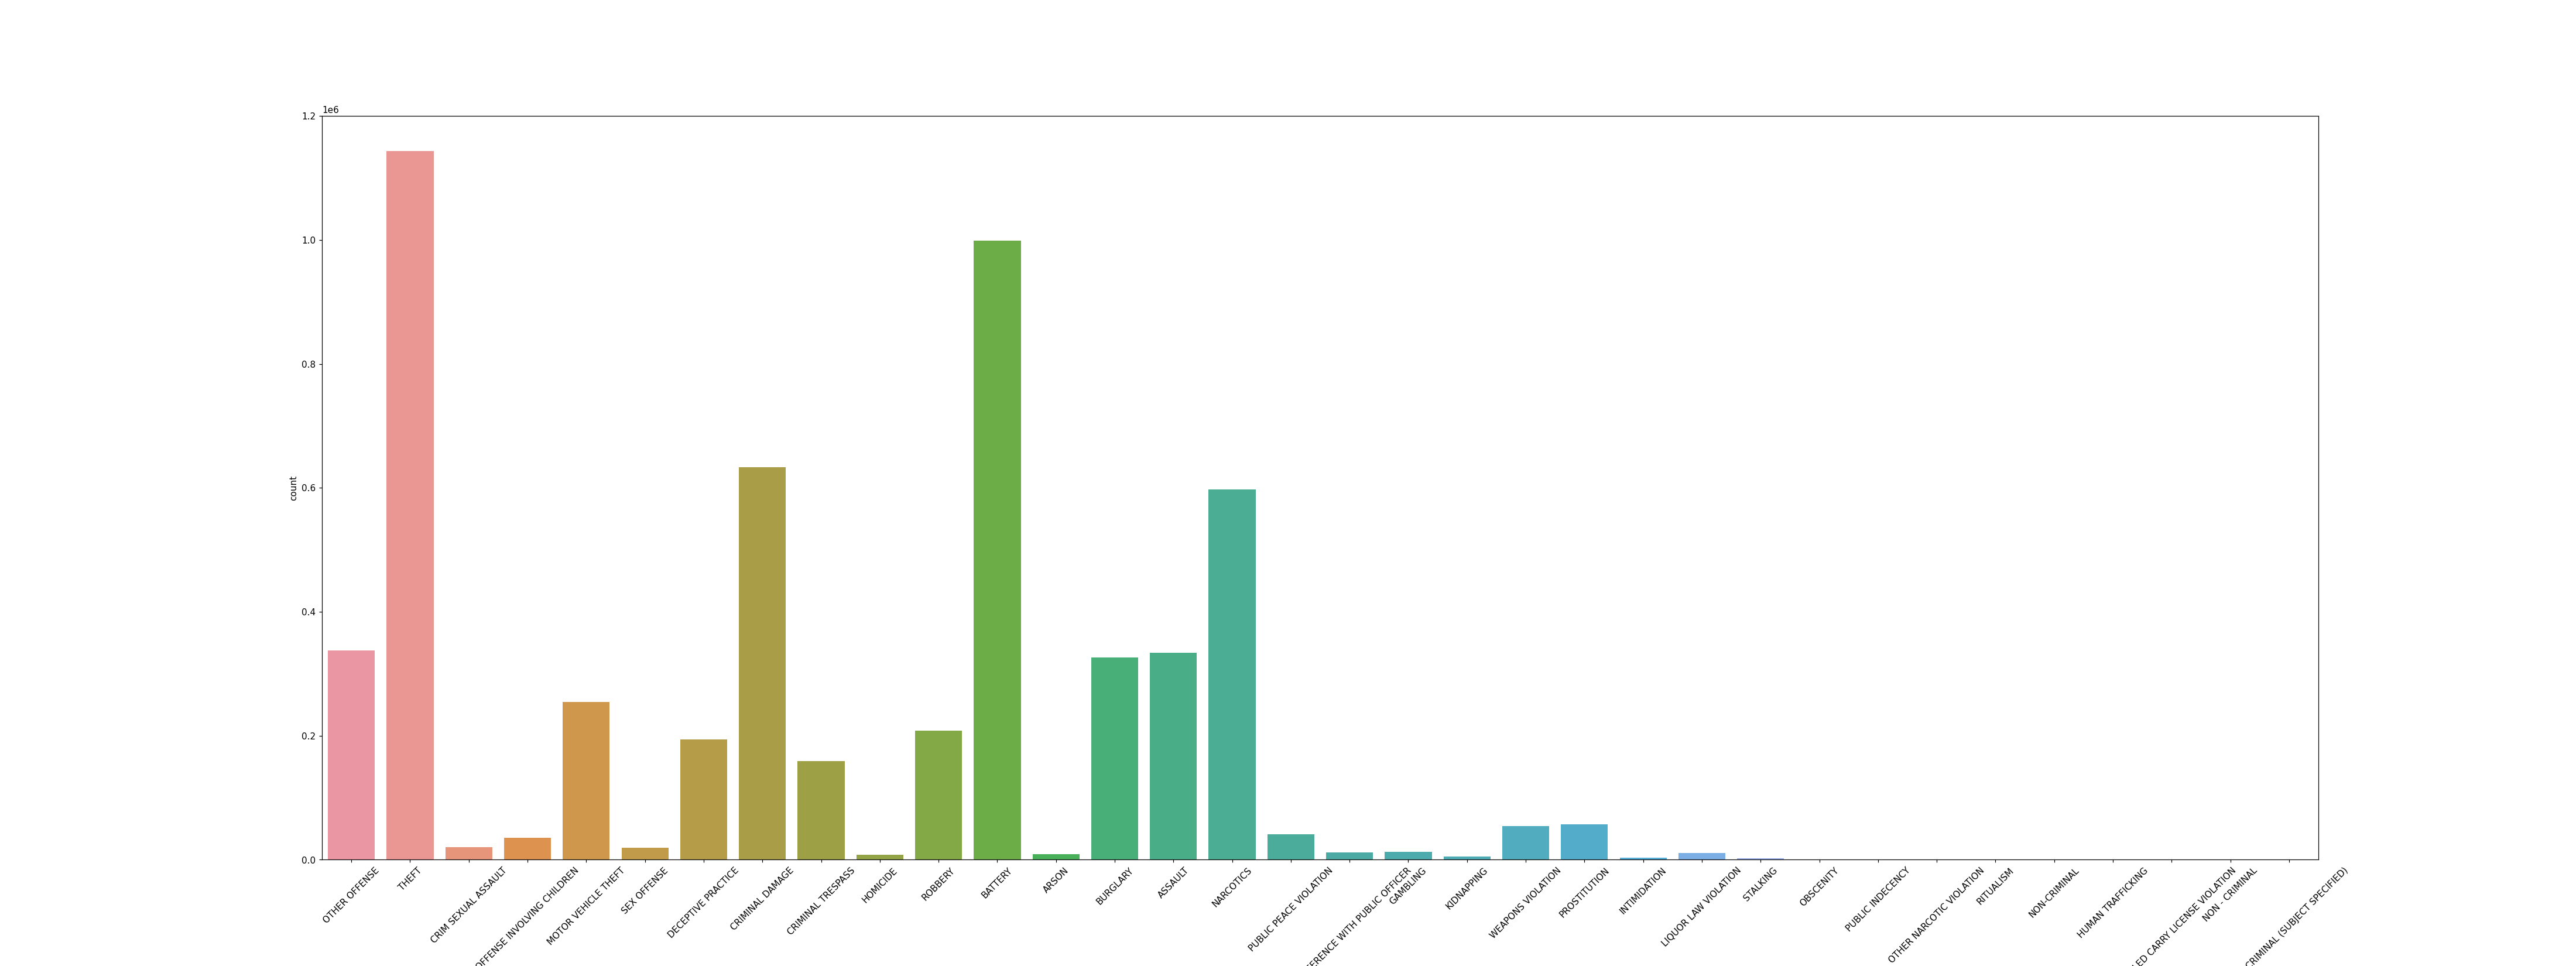

In [4]:
classes = set(crimeC['Primary Type'].values)
df = pd.DataFrame(columns=['Crime', 'Ocurrence'])

for index in classes:
    #print("Repeticiones ", index, ": ", list(crimeC['Primary Type'].values).count(index))
    aux = pd.DataFrame([[index, list(crimeC['Primary Type'].values).count(index)]], columns=['Crime', 'Ocurrence'])
    df = pd.concat([df, aux], axis=0)

#sns.histplot(data=df, x=df['Crime'])
#df = crimeC['Primary Type']
#print(df)
plt.figure(figsize=(40,15))
chart = sns.countplot(data=crimeC, x='Primary Type')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.get_figure().savefig("images/crimesCountplot.png")

<IPython.core.display.Javascript object>


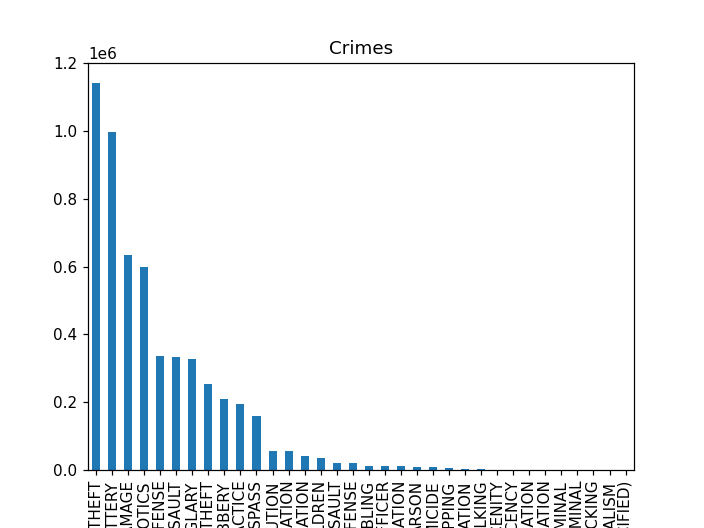

In [197]:
plt.figure()
crimeC['Primary Type'].value_counts().plot.bar()
plt.title("Crimes")
plt.show()

In [5]:
df

Crime Ocurrence
0                            ASSAULT    334045
0   INTERFERENCE WITH PUBLIC OFFICER     12250
0  CONCEALED CARRY LICENSE VIOLATION        84
0                CRIM SEXUAL ASSAULT     20166
0                         KIDNAPPING      5022
0                MOTOR VEHICLE THEFT    254388
0                   PUBLIC INDECENCY       124
0                        SEX OFFENSE     18975
0                       NON-CRIMINAL        80
0                  WEAPONS VIOLATION     54516
0   NON-CRIMINAL (SUBJECT SPECIFIED)         4
0                  CRIMINAL TRESPASS    159349
0         OFFENSE INVOLVING CHILDREN     35484
0                       PROSTITUTION     56985
0                           BURGLARY    326234
0                           HOMICIDE      7812
0                            BATTERY    998674
0                          NARCOTICS    597701
0                       INTIMIDATION      3171
0                 DECEPTIVE PRACTICE    194091
0             PUBLIC PEACE VIOLATION     41041
0                           STALKING      2626
0                    CRIMINAL DAMAGE    633246
0           OTHER NARCOTIC VIOLATION       101
0               LIQUOR LAW VIOLATION     11291
0                              THEFT   1143153
0                           GAMBLING     12669
0                          OBSCENITY       363
0                          RITUALISM        13
0                              ARSON      8863
0                            ROBBERY    207996
0                      OTHER OFFENSE    337754
0                  HUMAN TRAFFICKING        20
0                     NON - CRIMINAL        38

A partir d'aquí eliminarem els tipus de crim que no passin dels 100.000 casos, per tal de centrar-nos en els que més es repeteixen

In [6]:
types = df['Crime'].values
ocurrence = df['Ocurrence'].values
crimes = zip(types,ocurrence)

In [7]:
THRESHOLD = 100000
for crime, repetitions in crimes:
    if(repetitions < THRESHOLD):
        crimeC = crimeC.drop(crimeC.index[crimeC['Primary Type'] == crime])

In [8]:
crimeC.shape

(5186631, 17)

In [9]:
crimeC['Primary Type'].unique()

array(['OTHER OFFENSE', 'THEFT', 'MOTOR VEHICLE THEFT',
       'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS',
       'ROBBERY', 'BATTERY', 'BURGLARY', 'ASSAULT', 'NARCOTICS'],
      dtype=object)

<IPython.core.display.Javascript object>


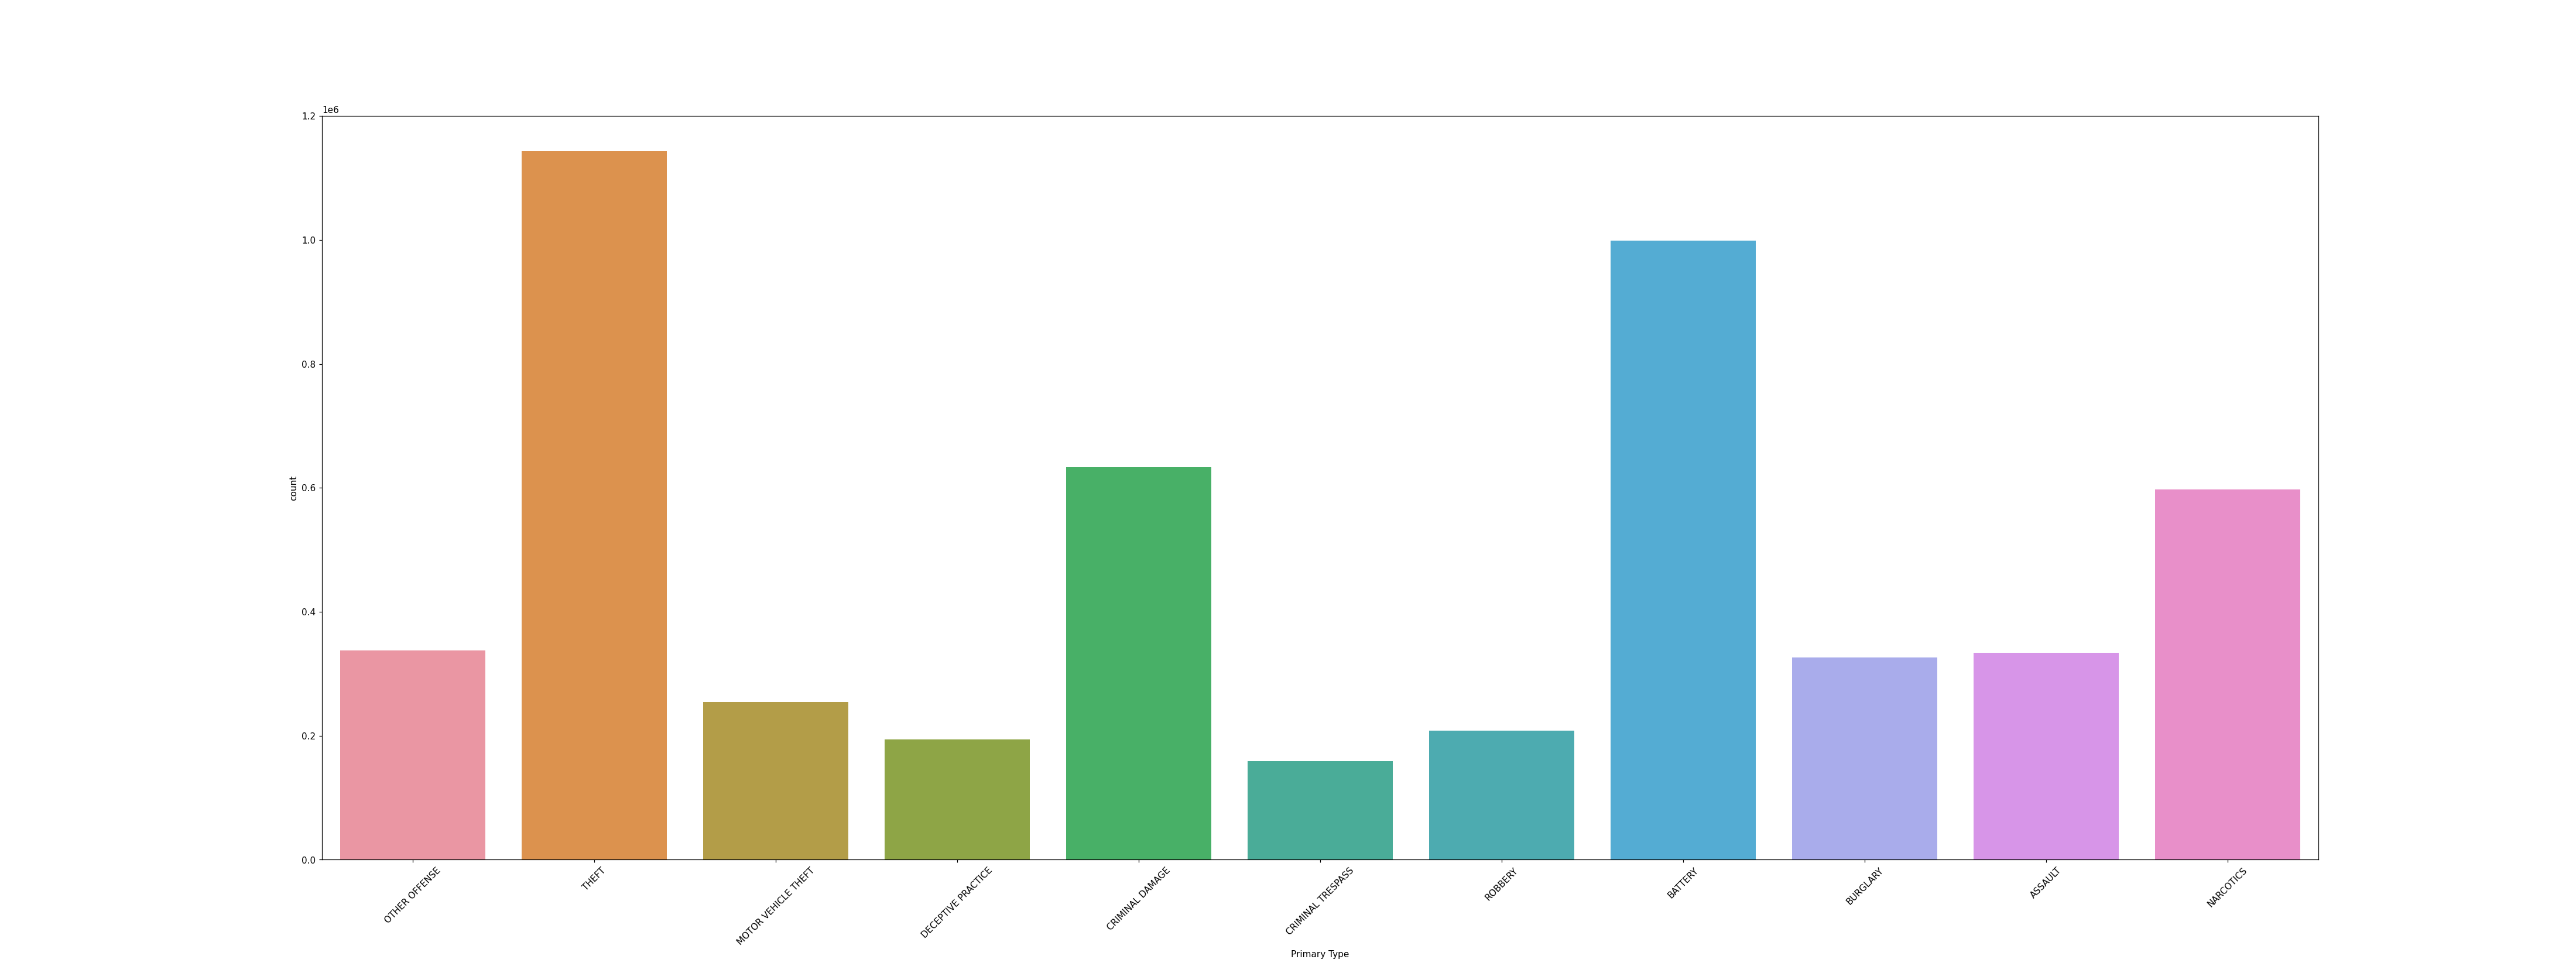

In [10]:
classes = set(crimeC['Primary Type'].values)
df = pd.DataFrame(columns=['Crime', 'Ocurrence'])

for index in classes:
    #print("Repeticiones ", index, ": ", list(crimeC['Primary Type'].values).count(index))
    aux = pd.DataFrame([[index, list(crimeC['Primary Type'].values).count(index)]], columns=['Crime', 'Ocurrence'])
    df = pd.concat([df, aux], axis=0)

#sns.histplot(data=df, x=df['Crime'])
#df = crimeC['Primary Type']
#print(df)
plt.figure(figsize=(40,15))
chart = sns.countplot(data=crimeC, x='Primary Type')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart.get_figure().savefig("images/crimesCountplot_v2.png")

Guardem el dataset amb els canvis

In [11]:
crimeC.to_csv("data/Chicago_Crimes_2001_to_2017_parsed_v2.csv", index=False)

In [12]:
crimeC = load_dataset("data/Chicago_Crimes_2001_to_2017_parsed_v2.csv")

C:\Users\adria\AppData\Local\Temp\ipykernel_11484\1449035986.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)


In [14]:
crimeC['Date'] = crimeC['Date'].astype('datetime64[ns]')

Mostrem la quantitat de crims d'un mateix tipus per any.

In [15]:
##Update crime tags
crimes = crimeC['Primary Type'].unique()

years = crimeC['Year'].unique()
years.sort()
result = pd.DataFrame(columns=['Year', 'Crime', 'Ocurrence'])

for year in years:
    for crime in crimes:
        tuple1 = np.where((crimeC['Primary Type'] == crime) & (crimeC['Year'] == year))
        aux = pd.DataFrame([[year, crime, len(tuple1[0])]], columns=['Year', 'Crime', 'Ocurrence'])
        result = pd.concat([result, aux], axis=0)

In [16]:
result.reset_index(drop=True, inplace=True)
result[0:23]

Year                Crime Ocurrence
0  2001.000        OTHER OFFENSE       181
1  2001.000                THEFT      1214
2  2001.000  MOTOR VEHICLE THEFT       639
3  2001.000   DECEPTIVE PRACTICE       394
4  2001.000      CRIMINAL DAMAGE        76
5  2001.000    CRIMINAL TRESPASS        11
6  2001.000              ROBBERY        36
7  2001.000              BATTERY       147
8  2001.000             BURGLARY        38
9  2001.000              ASSAULT        46
10 2001.000            NARCOTICS       120
11 2002.000        OTHER OFFENSE     22150
12 2002.000                THEFT     71663
13 2002.000  MOTOR VEHICLE THEFT     17493
14 2002.000   DECEPTIVE PRACTICE      9983
15 2002.000      CRIMINAL DAMAGE     39619
16 2002.000    CRIMINAL TRESPASS      9497
17 2002.000              ROBBERY     13152
18 2002.000              BATTERY     67919
19 2002.000             BURGLARY     18921
20 2002.000              ASSAULT     22757
21 2002.000            NARCOTICS     33977
22 2003.000        OTHER OFFENSE     30815

Com es pot veure l'any 2001 té molt pocs casos en comparació amb la resta, per tant, decideixo borrar les files per aquest any.

In [20]:
crimeC = crimeC.drop(crimeC.index[crimeC['Year'] == 2001])

In [21]:
##Update crime tags
crimes = crimeC['Primary Type'].unique()

years = crimeC['Year'].unique()
years.sort()
result = pd.DataFrame(columns=['Year', 'Crime', 'Ocurrence'])

for year in years:
    for crime in crimes:
        tuple1 = np.where((crimeC['Primary Type'] == crime) & (crimeC['Year'] == year))
        aux = pd.DataFrame([[year, crime, len(tuple1[0])]], columns=['Year', 'Crime', 'Ocurrence'])
        result = pd.concat([result, aux], axis=0)

In [36]:
result.reset_index(drop=True, inplace=True)
result[150:180]

Year                Crime Ocurrence
150 2015.000      CRIMINAL DAMAGE     28526
151 2015.000              ASSAULT     16945
152 2015.000            NARCOTICS     22839
153 2015.000    CRIMINAL TRESPASS      6382
154 2016.000        OTHER OFFENSE     15910
155 2016.000                THEFT     58328
156 2016.000  MOTOR VEHICLE THEFT     11005
157 2016.000   DECEPTIVE PRACTICE     13511
158 2016.000             BURGLARY     13612
159 2016.000              ROBBERY     11611
160 2016.000              BATTERY     48686
161 2016.000      CRIMINAL DAMAGE     30189
162 2016.000              ASSAULT     18080
163 2016.000            NARCOTICS     10664
164 2016.000    CRIMINAL TRESPASS      6209

Gràfics per número de crims d'un sol tipus per any.

<IPython.core.display.Javascript object>


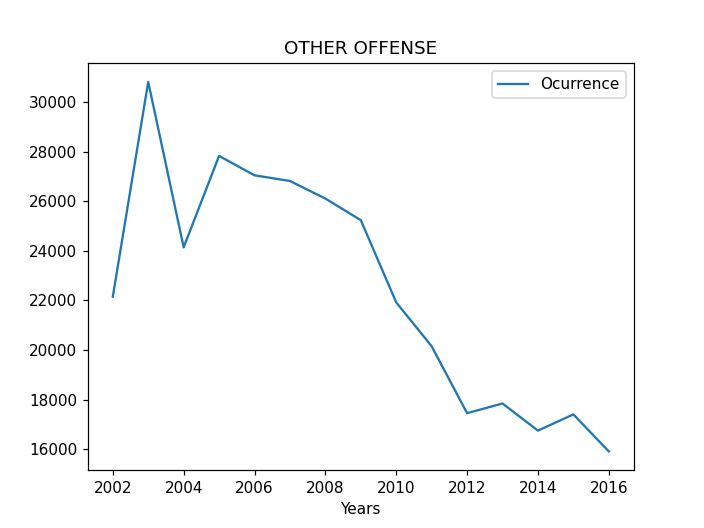

<IPython.core.display.Javascript object>


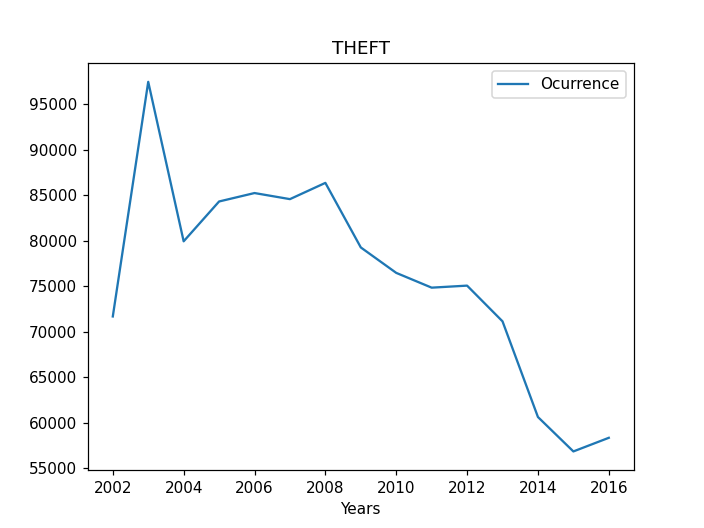

<IPython.core.display.Javascript object>


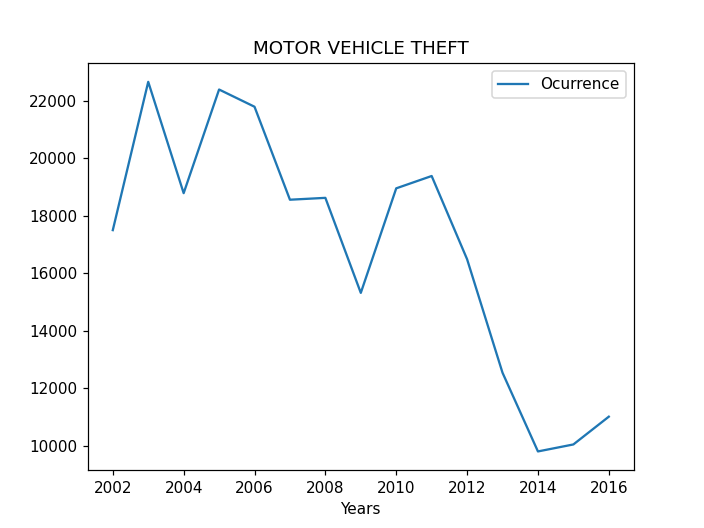

<IPython.core.display.Javascript object>


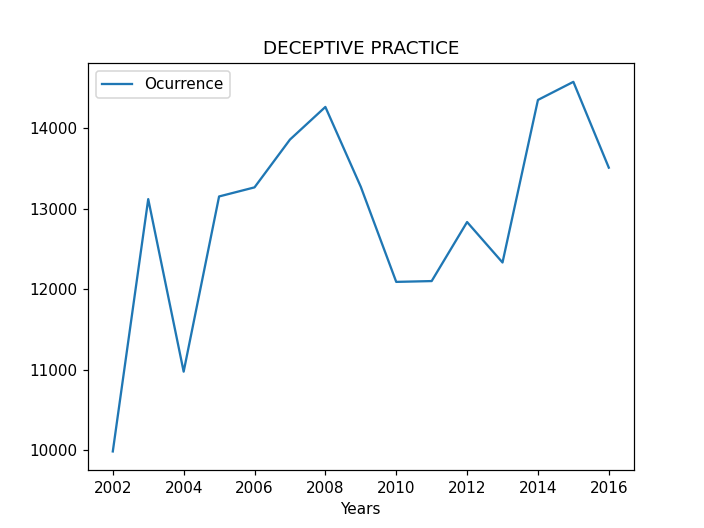

<IPython.core.display.Javascript object>


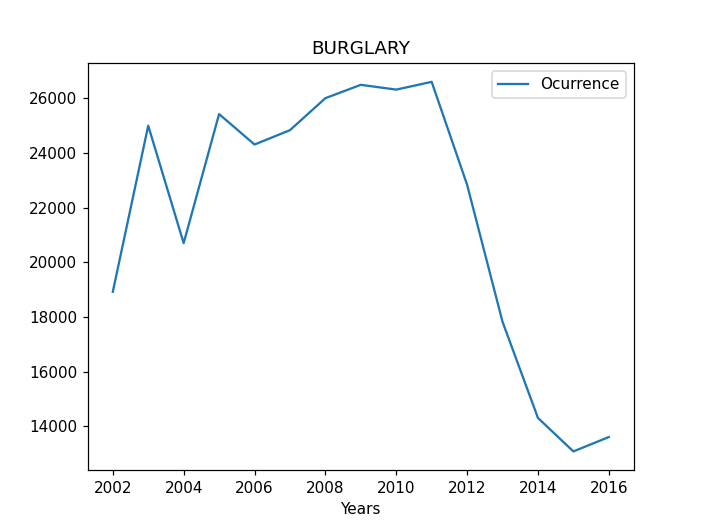

<IPython.core.display.Javascript object>


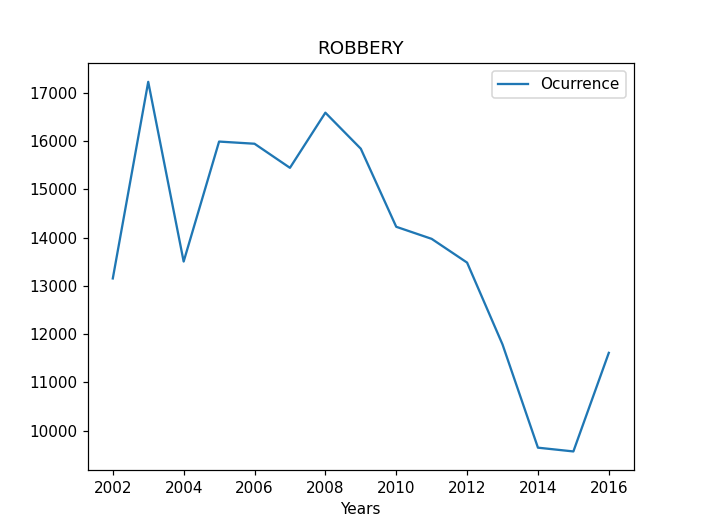

<IPython.core.display.Javascript object>


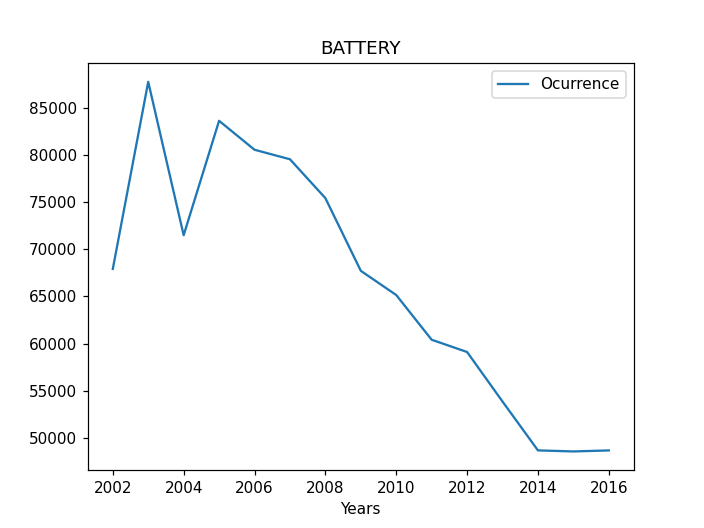

<IPython.core.display.Javascript object>


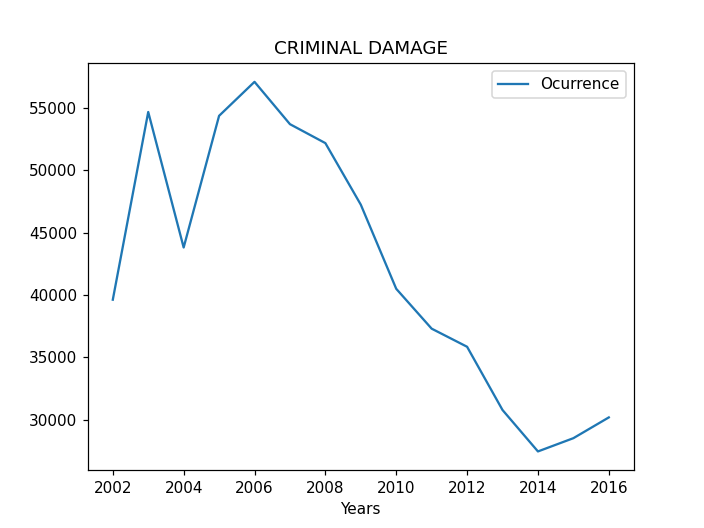

<IPython.core.display.Javascript object>


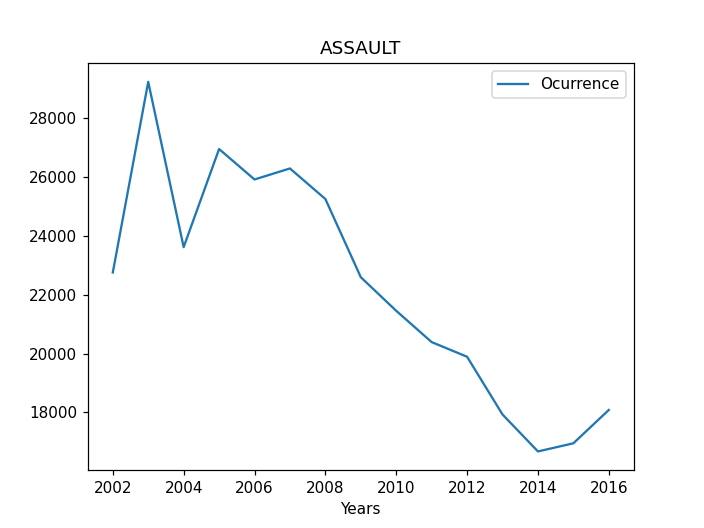

<IPython.core.display.Javascript object>


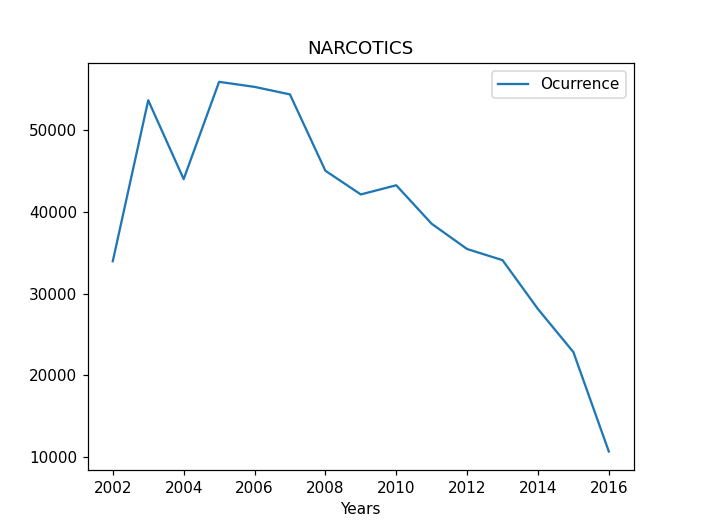

<IPython.core.display.Javascript object>


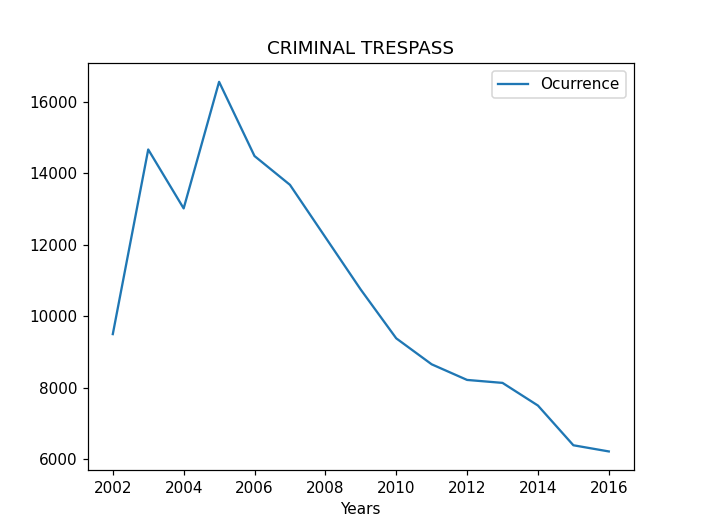

In [23]:
years = list(result['Year'].unique())
crimes = result['Crime'].unique()

for crime in crimes:
    indexes = np.where(result['Crime'] == crime)
    for index in indexes:
        ocurrences = list(result['Ocurrence'][index])
        
    aux = list(zip(years, ocurrences))
    df = pd.DataFrame(aux, columns=['Years', 'Ocurrence'])
    
    
    plt = df.plot(x = 'Years', y = 'Ocurrence', title=crime)

In [27]:
crimeC.to_csv("data/Chicago_Crimes_2001_to_2017_parsed_v3.csv", index=False)

In [15]:
crimeC = load_dataset("data/Chicago_Crimes_2001_to_2017_parsed_v3.csv")

C:\Users\adria\AppData\Local\Temp\ipykernel_18160\1449035986.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)


In [16]:
crimeC['Date'] = crimeC['Date'].astype('datetime64[ns]')

In [10]:
crimeC.describe()

ID        Beat    District        Ward  Community Area  \
count  5183729.000 5183729.000 5183729.000 5183729.000     5183729.000   
mean   6318955.222    1193.083      11.304      22.655          37.617   
std    2550626.694     703.728       6.946      13.854          21.574   
min    1918036.000     111.000       1.000       1.000           0.000   
25%    4038735.000     622.000       6.000      10.000          23.000   
50%    6352803.000    1111.000      10.000      22.000          32.000   
75%    8505888.000    1731.000      17.000      34.000          58.000   
max   10823344.000    2535.000      31.000      50.000          77.000   

       X Coordinate  Y Coordinate        Year    Latitude   Longitude  
count   5183729.000   5183729.000 5183729.000 5183729.000 5183729.000  
mean    1164509.026   1885583.889    2008.333      41.842     -87.672  
std       17503.721     33195.419       4.108       0.091       0.063  
min           0.000         0.000    2002.000      36.619     -91.687  
25%     1152933.000   1858905.000    2005.000      41.768     -87.714  
50%     1165994.000   1890281.000    2008.000      41.855     -87.666  
75%     1176352.000   1909397.000    2012.000      41.907     -87.628  
max     1205119.000   1951573.000    2016.000      42.023     -87.525

In [38]:
result

Year                Crime Ocurrence
0   2002.000        OTHER OFFENSE     22150
1   2002.000                THEFT     71663
2   2002.000  MOTOR VEHICLE THEFT     17493
3   2002.000   DECEPTIVE PRACTICE      9983
4   2002.000             BURGLARY     18921
..       ...                  ...       ...
160 2016.000              BATTERY     48686
161 2016.000      CRIMINAL DAMAGE     30189
162 2016.000              ASSAULT     18080
163 2016.000            NARCOTICS     10664
164 2016.000    CRIMINAL TRESPASS      6209

[165 rows x 3 columns]

Preparem un nou dataset temporal per mostrar el total de crims per any, per veure una evolució de la criminalitat a través dels anys

In [63]:
years = list(result['Year'].unique())
total = [0]*len(years)
dataList = list(zip(years,total))
totalCrimesYear = pd.DataFrame(dataList,columns=['Year', 'Total'])

totalCrimesYear

Year  Total
0  2002.000      0
1  2003.000      0
2  2004.000      0
3  2005.000      0
4  2006.000      0
5  2007.000      0
6  2008.000      0
7  2009.000      0
8  2010.000      0
9  2011.000      0
10 2012.000      0
11 2013.000      0
12 2014.000      0
13 2015.000      0
14 2016.000      0

In [64]:
years = result['Year']
ocurrences = result['Ocurrence']

for i in range(len(result['Year'])):
    for j in range(len(totalCrimesYear['Year'])):
        if(result['Year'][i] == totalCrimesYear['Year'][j]):
            totalCrimesYear['Total'][j] += result['Ocurrence'][i]

C:\Users\adria\AppData\Local\Temp\ipykernel_11484\699893407.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalCrimesYear['Total'][j] += result['Ocurrence'][i]


Comprovem que tenim un resultat correcte

In [65]:
total = totalCrimesYear['Total'].sum()
total

5183729

In [66]:
totalCrimesYear

Year   Total
0  2002.000  327131
1  2003.000  446251
2  2004.000  363975
3  2005.000  426501
4  2006.000  420925
5  2007.000  411660
6  2008.000  398025
7  2009.000  365832
8  2010.000  349694
9  2011.000  332332
10 2012.000  316669
11 2013.000  288254
12 2014.000  253897
13 2015.000  244778
14 2016.000  237805

Fem el plot de total de crims per any.

<IPython.core.display.Javascript object>


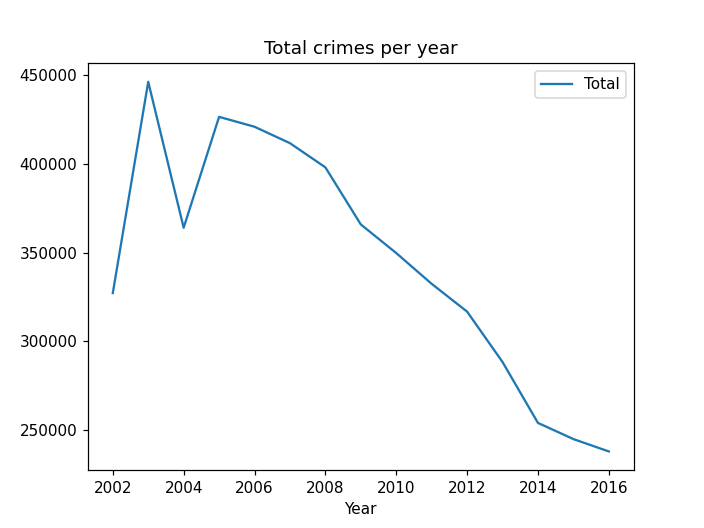

In [68]:
plt = totalCrimesYear.plot(x = 'Year', y = 'Total', title='Total crimes per year')

<IPython.core.display.Javascript object>


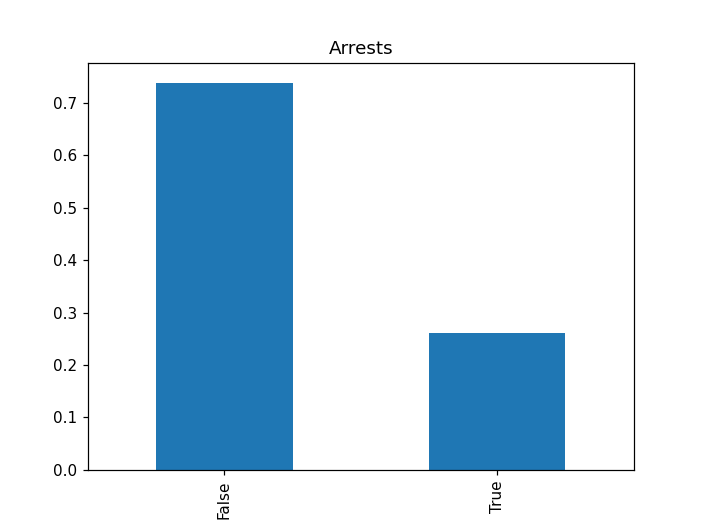

In [79]:
plt.figure()
crimeC['Arrest'].value_counts(normalize=True).plot.bar()
plt.title("Arrests")
plt.show()

<IPython.core.display.Javascript object>


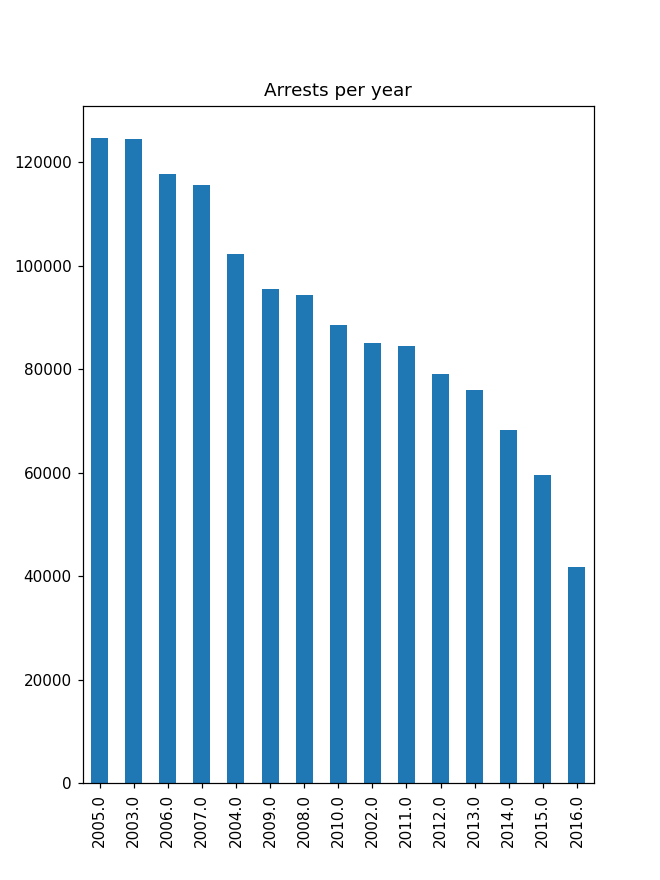

In [91]:
plt.figure(figsize=(6,8))
crimeC[crimeC.Arrest == True]['Year'].value_counts().plot.bar()
plt.title("Arrests per year")
plt.show()

Passem les variables categòriques a numèriques.

In [17]:
crimeC = crimeC.drop(['Block', 'Description'], axis=1)

In [18]:
printColumnTypes(crimeC)

ID <class 'numpy.int64'>
Date <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Primary Type <class 'str'>
Location Description <class 'str'>
Arrest <class 'numpy.bool_'>
Domestic <class 'numpy.bool_'>
Beat <class 'numpy.int64'>
District <class 'numpy.float64'>
Ward <class 'numpy.float64'>
Community Area <class 'numpy.float64'>
X Coordinate <class 'numpy.float64'>
Y Coordinate <class 'numpy.float64'>
Year <class 'numpy.float64'>
Latitude <class 'numpy.float64'>
Longitude <class 'numpy.float64'>
-------------------------------------------------------
(5183729, 15)


In [19]:
primaryTypes = list(crimeC['Primary Type'].unique())
lenPrimaryTypes = list(range(len(crimeC['Primary Type'].unique())))
print("Primary types:", primaryTypes)
print("Range primary types: ",lenPrimaryTypes)
print("----------------------------------------------------------------------------------------------------------------")
locationDescription = list(crimeC['Location Description'].unique())
lenLocationDescription = list(range(len(crimeC['Location Description'].unique())))
print("Location Description:", locationDescription)
print("Range location description:", lenLocationDescription)

Primary types: ['OTHER OFFENSE', 'THEFT', 'MOTOR VEHICLE THEFT', 'DECEPTIVE PRACTICE', 'BURGLARY', 'ROBBERY', 'BATTERY', 'CRIMINAL DAMAGE', 'ASSAULT', 'NARCOTICS', 'CRIMINAL TRESPASS']
Range primary types:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
----------------------------------------------------------------------------------------------------------------
Location Description: ['RESIDENCE', 'RESIDENCE PORCH/HALLWAY', 'APARTMENT', 'GAS STATION', 'COMMERCIAL / BUSINESS OFFICE', 'OTHER', 'STREET', 'BANK', 'APPLIANCE STORE', 'PARKING LOT/GARAGE(NON.RESID.)', 'CHURCH/SYNAGOGUE/PLACE OF WORSHIP', 'HOSPITAL BUILDING/GROUNDS', 'ALLEY', 'SMALL RETAIL STORE', 'HOTEL/MOTEL', 'SCHOOL, PRIVATE, BUILDING', 'CHA HALLWAY/STAIRWELL/ELEVATOR', 'SCHOOL, PUBLIC, BUILDING', 'DEPARTMENT STORE', 'OTHER RAILROAD PROP / TRAIN DEPOT', 'RESTAURANT', 'CTA TRAIN', 'GROCERY FOOD STORE', 'VACANT LOT/LAND', 'SIDEWALK', 'BAR OR TAVERN', 'RESIDENCE-GARAGE', 'DRIVEWAY - RESIDENTIAL', 'AIRPORT/AIRCRAFT', 'TAVERN/LIQUOR STOR

Gràfic amb el número de crims per localització, és a dir, on es produeix el crim.

<IPython.core.display.Javascript object>


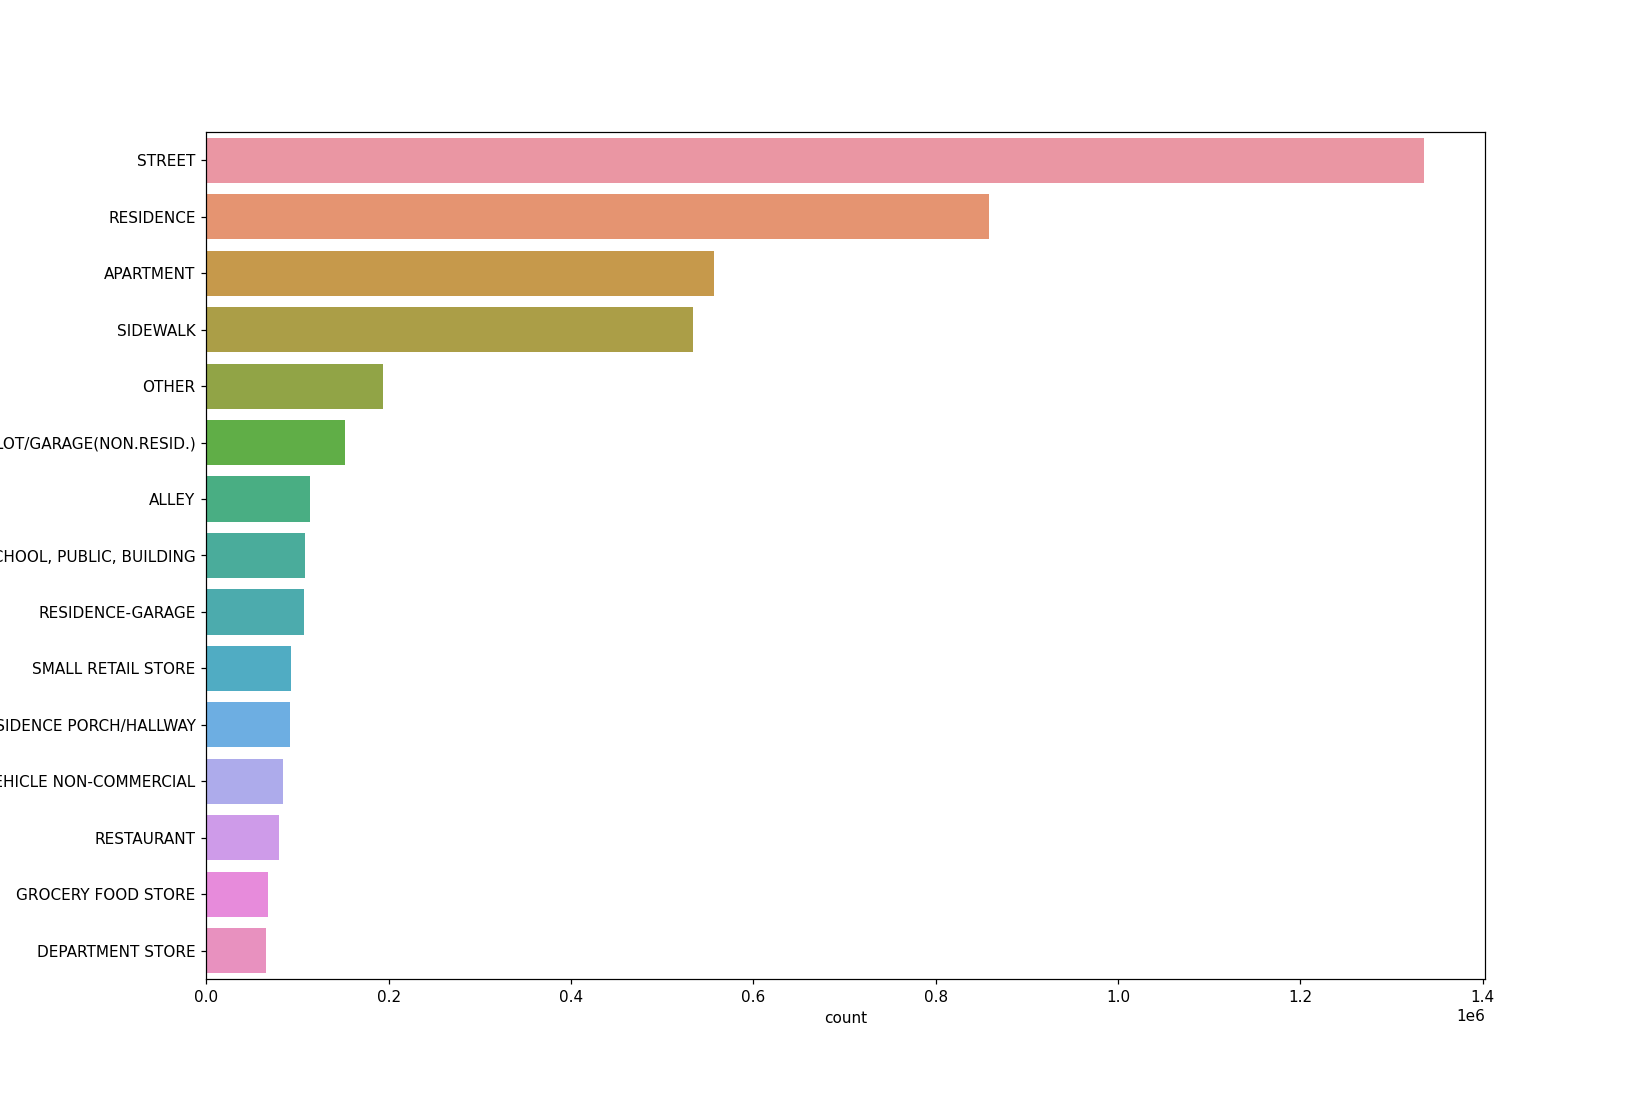

<AxesSubplot: xlabel='count', ylabel='Location Description'>

In [23]:
plt.figure(figsize = (15, 10))
sns.countplot(y= 'Location Description', data = crimeC, order = crimeC['Location Description'].value_counts().iloc[:15].index)

<IPython.core.display.Javascript object>


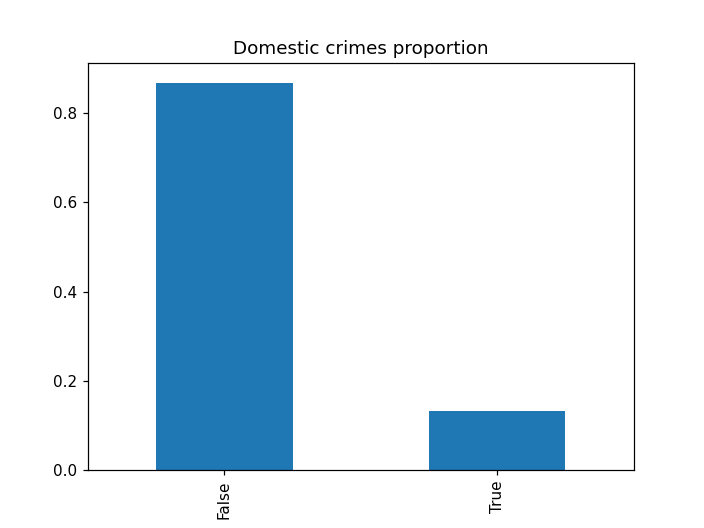

In [25]:
plt.figure()
crimeC['Domestic'].value_counts(normalize=True).plot.bar()
plt.title("Domestic crimes proportion")
plt.show()

In [36]:
domestic = len(crimeC.loc[crimeC['Domestic'] == True, 'Primary Type'].iloc[:])
crimeC.loc[crimeC['Domestic'] == True, 'Primary Type'].iloc[:].unique()

array(['OTHER OFFENSE', 'THEFT', 'DECEPTIVE PRACTICE', 'ROBBERY',
       'BATTERY', 'CRIMINAL DAMAGE', 'ASSAULT', 'MOTOR VEHICLE THEFT',
       'BURGLARY', 'CRIMINAL TRESPASS', 'NARCOTICS'], dtype=object)

Percentatge de crims en domicili respecte el total de crims

In [37]:
domesticRate = (domestic/len(crimeC)) * 100
domesticRate

13.181379659314752

Gràfic per veure l'evolució dels crims en domicilis per any.

<IPython.core.display.Javascript object>


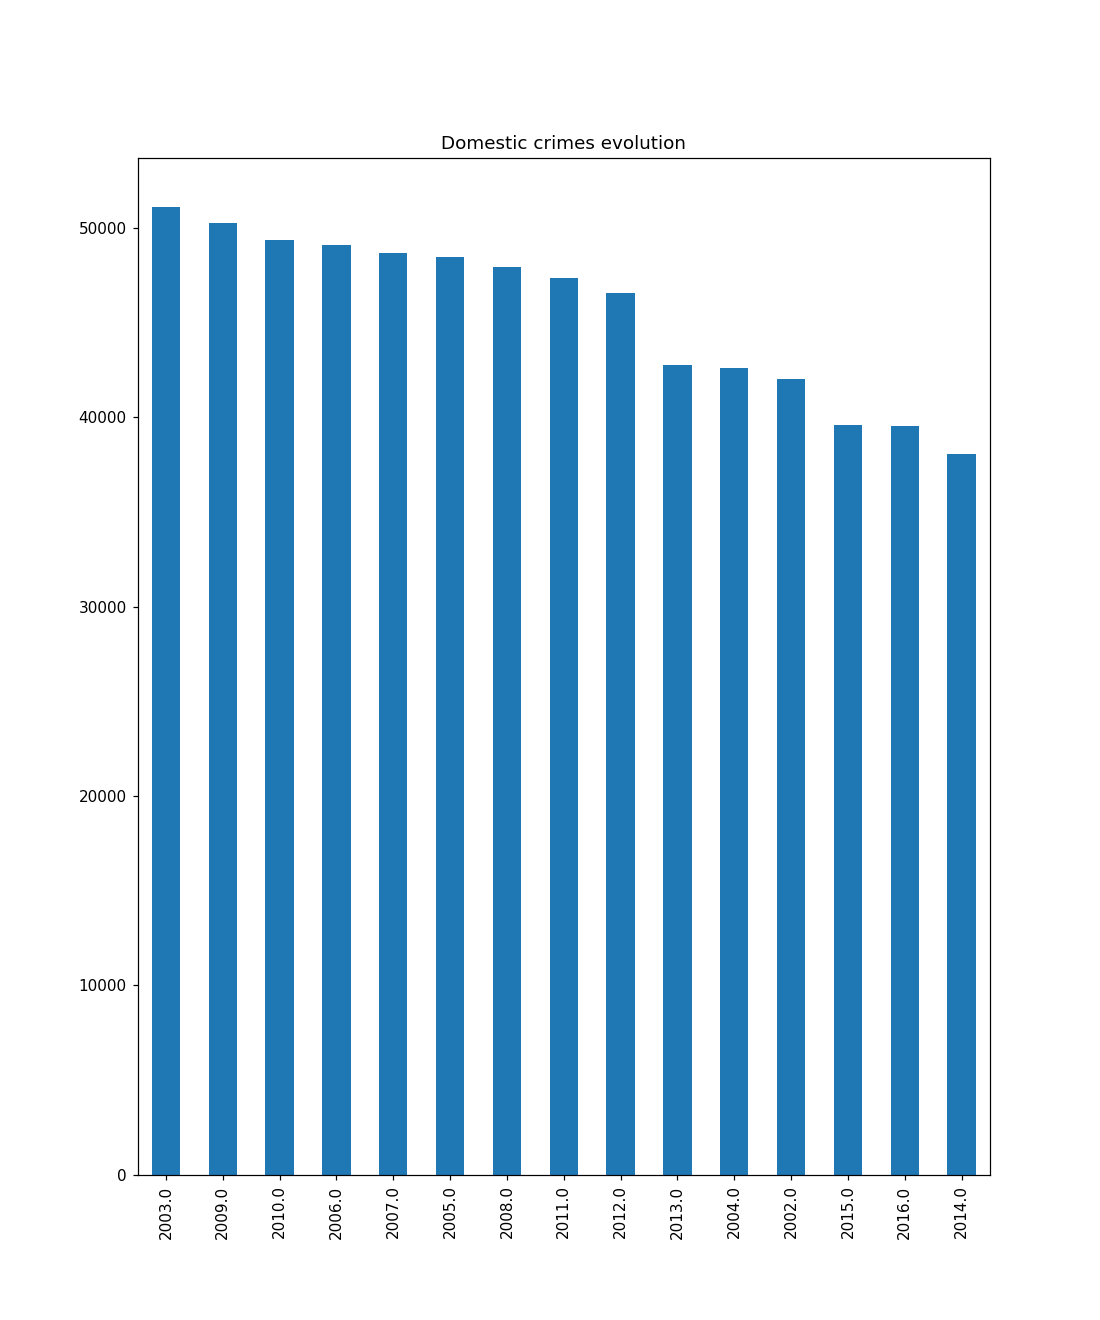

In [47]:
plt.figure(figsize = (10,12))
crimeC.loc[crimeC['Domestic'] == True, 'Year'].iloc[:].value_counts().plot.bar()
plt.title("Domestic crimes evolution")
plt.show()

Transformem les columnes Primary Type i Location Description a numèriques

In [48]:
crimeC['Primary Type'].replace(primaryTypes,lenPrimaryTypes, inplace=True)
crimeC['Location Description'].replace(locationDescription,lenLocationDescription, inplace=True)

In [49]:
crimeC['Primary Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [50]:
crimeC['Location Description'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

<IPython.core.display.Javascript object>


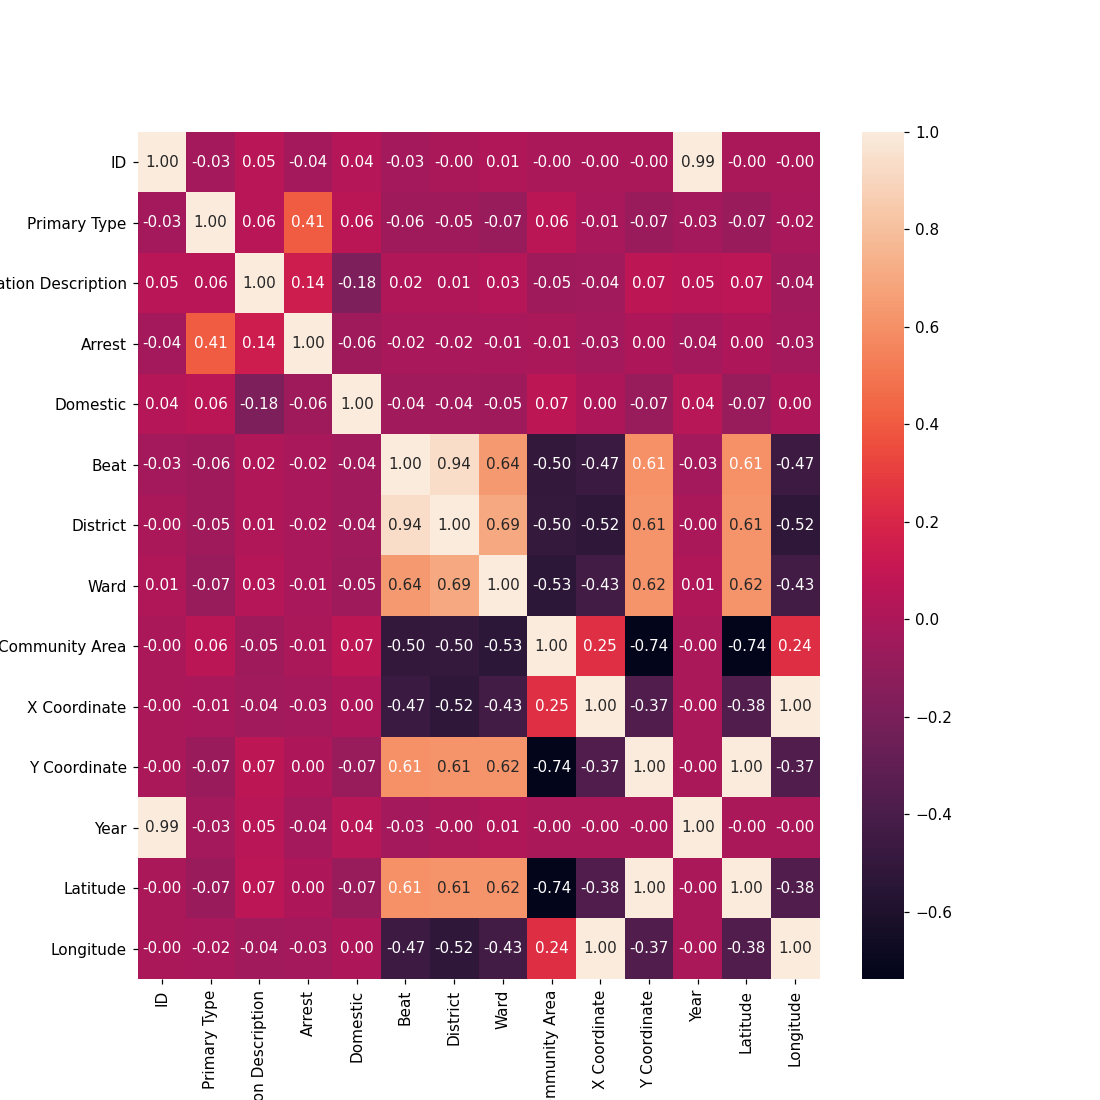

In [55]:
correlacio = crimeC.corr()

plt.figure(figsize = (10,10))

ax = sns.heatmap(correlacio, annot=True, fmt='.2f')
ax.get_figure().savefig("images/correlacioHeatMap.png")

Amb tot això ja podem començar a fer les primeres regressions, per tractar de predir el tipus de crims

In [56]:
crimeC.head()

ID                Date  Primary Type  Location Description  Arrest  \
0  4676906 2003-03-01 00:00:00             0                     0   False   
1  4677901 2003-05-01 01:00:00             1                     0   False   
2  4679521 2003-03-15 00:00:00             0                     1   False   
3  4680124 2003-01-01 00:00:00             1                     0   False   
4  4682244 2003-06-05 00:00:00             1                     0   False   

   Domestic  Beat  District   Ward  Community Area  X Coordinate  \
0      True   935     9.000 11.000          61.000   1173974.000   
1     False  2233    22.000 34.000          49.000   1174948.000   
2     False  2222    22.000 21.000          73.000   1169911.000   
3     False  1134    11.000 24.000          29.000   1154521.000   
4     False  2223    22.000 21.000          73.000   1173946.000   

   Y Coordinate     Year  Latitude  Longitude  
0   1876757.000 2003.000    41.817    -87.637  
1   1831051.000 2003.000    41.692    -87.635  
2   1844832.000 2003.000    41.730    -87.653  
3   1895755.000 2003.000    41.870    -87.708  
4   1842903.000 2003.000    41.724    -87.638

In [38]:
import math

def mean_squeared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

mean_squeared_error([1,2,3,4], [1,2,1,4])

1.0

In [39]:
import numpy as np #importem la llibreria
np.warnings.filterwarnings('ignore')

vector1 = np.array([1,2,3,4]) # convertim llista de python a numpy array
vector2 = np.array([1,2,1,4]) 

# podem sumar dos vectors element a element
print("Suma vector1 + vector2 ", vector1 + vector2)

# podem sumar tots els valors d'un vector
print("Suma valors vector1 ", vector1.sum())

# calculem la mitjana
print("Mitjana vector1", vector1.mean())

# utilitzem un vector com a índex de l'altre
# vector3 = vector1  # necesitem fer una copia del vector per no modificar el original
vector3 = vector1.copy()
vector3[vector2 == 1] = 5
print("Vector1 amb un 5 on el Vector2 te 1s ", vector3)

# es pot utilitzar numpy per a calcular el mse
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

print("MSE: ", mse(vector1, vector2))

Suma vector1 + vector2  [2 4 4 8]
Suma valors vector1  10
Mitjana vector1 2.5
Vector1 amb un 5 on el Vector2 te 1s  [5 2 5 4]
MSE:  1.0


Per a la regressió podeu utilitzar la llibreria sklearn:

In [40]:
from sklearn.linear_model import LinearRegression

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

Finalment, si la funció `fit` del regressor logístic dónes l'error: `ValueError: Unknown label type: 'unknown'`, caldria afegir a la definició de l'atribut a trobar $y$ la crida a la funció `.astype('int')` per tal de obligar a que les dades siguin de tipus sencer, deixant el codi com segueix:

`y = data[:,2].astype('int')`

A continuació, es modificaran tots els atributs mitjançant **procediments de normalització (normal, estàndard)**, i s'avaluarà el rendiment del regressor après. Per a això, caldrà analitzar la mitja i variança de cada variable per totes les mostres, per identificar aquells valors que tenen una distribució normal, els preferits per fer regressió, i descartar altres atributs que no són representatius per fer la regressió, i que afegeixen soroll al model. 

Pel que fa a l'error resultant de la regressió, recordeu que es calcula fent la diferència entre el valor predit i el real al quadrat: així doncs, si les dades tenen valors grans (tipus 10^3), l'error al quadrat podria acabar sent 10^6. Per això és important normalitzar abans (escalar les dades a un rang més petit).

<img src="images/standarization.png">

Podeu estandarditzar les dades amb les funcions mean i std de numpy i mostrar l'hisotgrama de nou. Recuperant l'exemple de l'apartat anterior:

In [41]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

x_t = standarize(x)

Regressió sense normalitzar

(67, 11)
Mean squeared error  YEAR :  4605950.294898352
R2 score:  0.8778191593718118
Mean squeared error  POUNDS GRADED :  1.1279788236430314e-23
R2 score:  1.0
Mean squeared error  PRIME :  21701983.512281522
R2 score:  0.4243171508458159
Mean squeared error  CHOICE :  8514741.790275076
R2 score:  0.7741316681554131
Mean squeared error  SELECT :  12769245.163558425
R2 score:  0.6612735682364921
Mean squeared error  STNDRD :  35771280.65717755
R2 score:  0.05110457968212667
Mean squeared error  COMRCL :  34175556.75569288
R2 score:  0.09343393089328511
Mean squeared error  UTILITY :  33798309.5722154
R2 score:  0.1034410684112359
Mean squeared error  CUTTER :  35478391.24225527
R2 score:  0.05887398070365746
Mean squeared error  %  of FEDERAL  SLAUGHTER	 BEEF :  12570033.243707655
R2 score:  0.6665580108101521
Mean squeared error  SUM :  427224.7768383689
R2 score:  0.9886671199146203


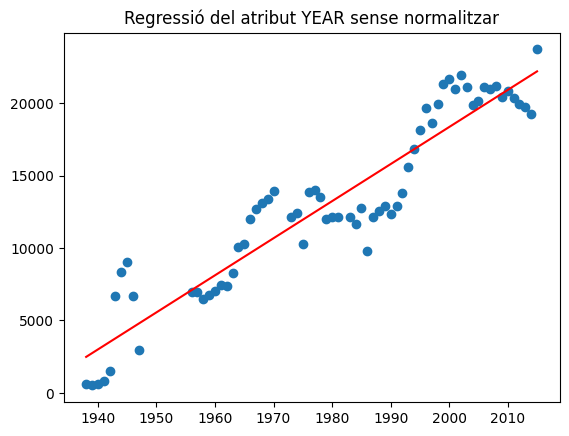

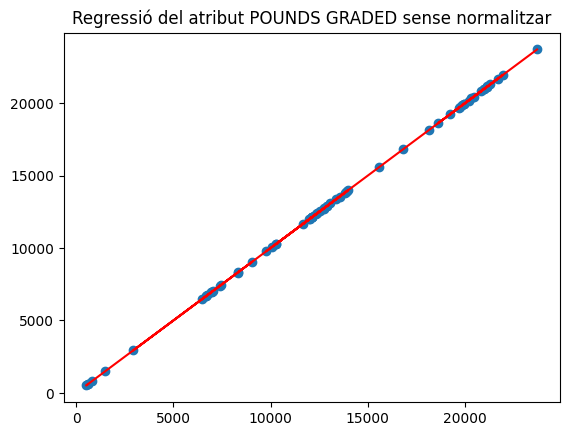

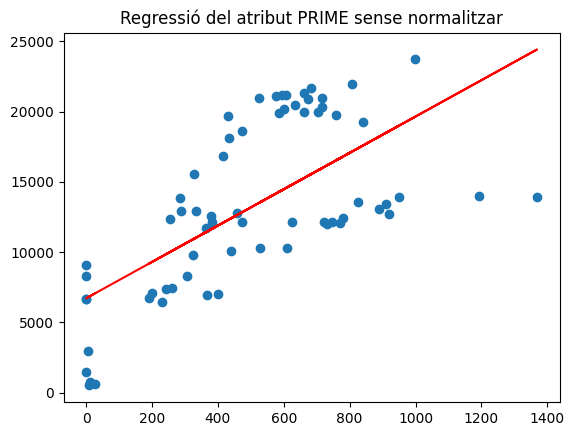

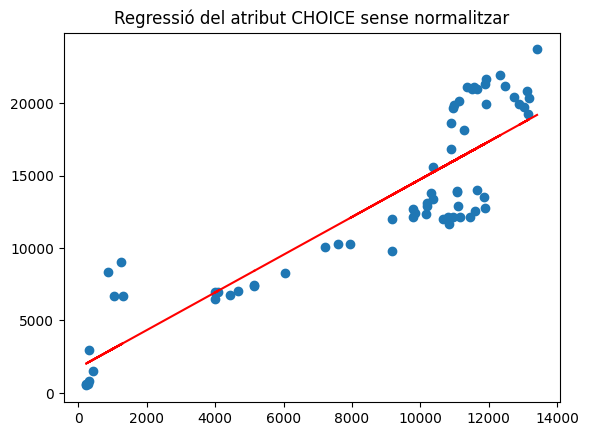

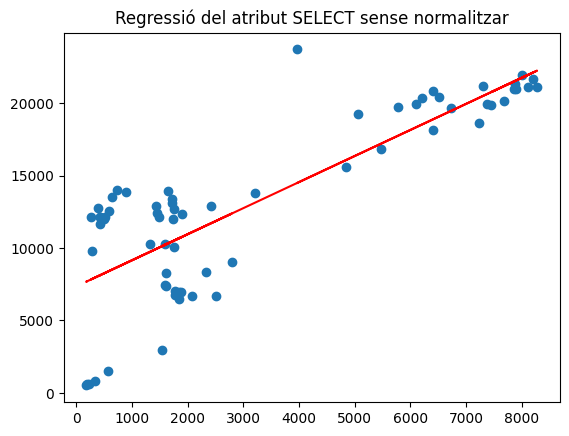

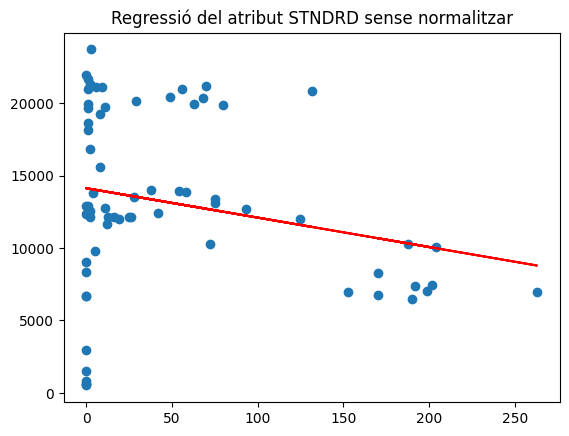

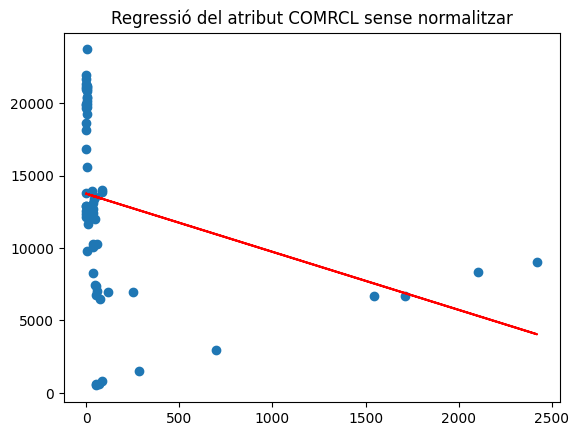

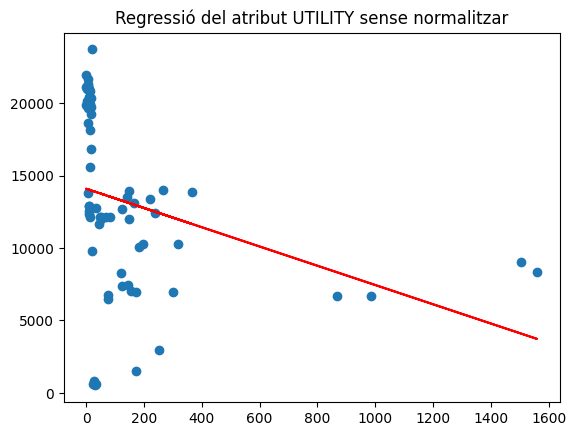

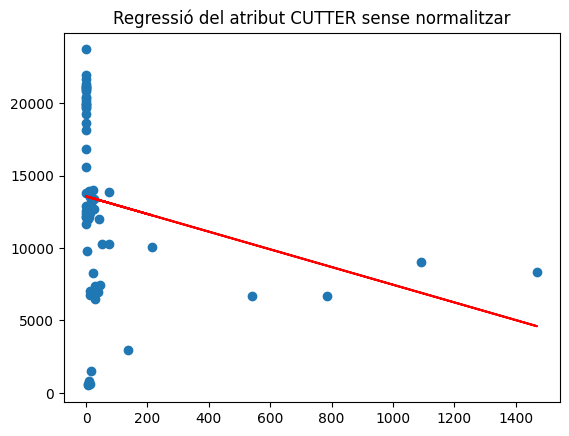

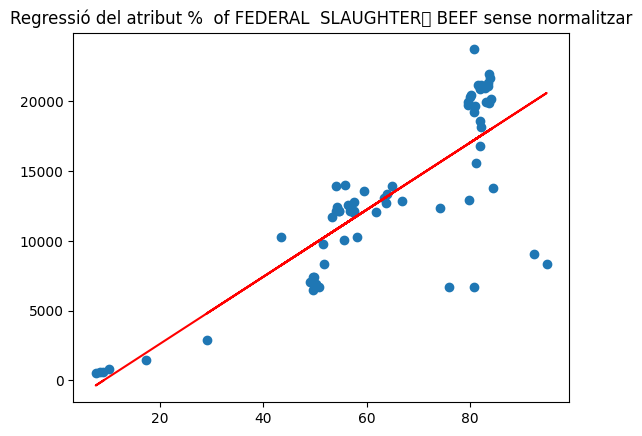

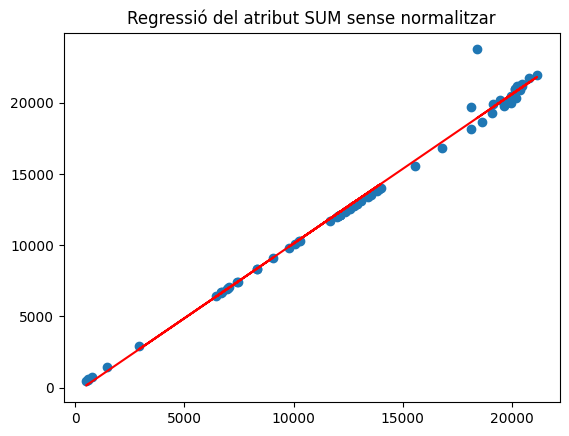

In [42]:
##dataset fill 0
from sklearn.metrics import r2_score

index = dfFill0.columns[:13]
print(xFill0.shape)
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
for index1 in range(xFill0.shape[1]):
    atribut1 = xFill0[:,index1].reshape(xFill0.shape[0], 1) 
    regr = regression(atribut1, yFill0) 
    predicted = regr.predict(atribut1)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {} sense normalitzar".format(index[index1]))
    ax = plt.scatter(xFill0[:,index1], yFill0)
    plt.plot(atribut1[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(yFill0, predicted)
    r2 = r2_score(yFill0, predicted)

    print("Mean squeared error ",index[index1],": ", MSE)
    print("R2 score: ", r2)

Amb estandarització

Mean squeared error  YEAR :  4605950.294898348
R2 score:  0.8778191593718119
Mean squeared error  POUNDS GRADED :  5.80261026716303e-25
R2 score:  1.0
Mean squeared error  PRIME :  21701983.512281522
R2 score:  0.4243171508458159
Mean squeared error  CHOICE :  8514741.790275076
R2 score:  0.7741316681554132
Mean squeared error  SELECT :  12769245.163558424
R2 score:  0.6612735682364921
Mean squeared error  STNDRD :  35771280.65717755
R2 score:  0.05110457968212667
Mean squeared error  COMRCL :  34175556.75569288
R2 score:  0.09343393089328511
Mean squeared error  UTILITY :  33798309.5722154
R2 score:  0.1034410684112359
Mean squeared error  CUTTER :  35478391.24225527
R2 score:  0.05887398070365746
Mean squeared error  %  of FEDERAL  SLAUGHTER	 BEEF :  12570033.243707657
R2 score:  0.666558010810152
Mean squeared error  SUM :  427224.7768383689
R2 score:  0.9886671199146203


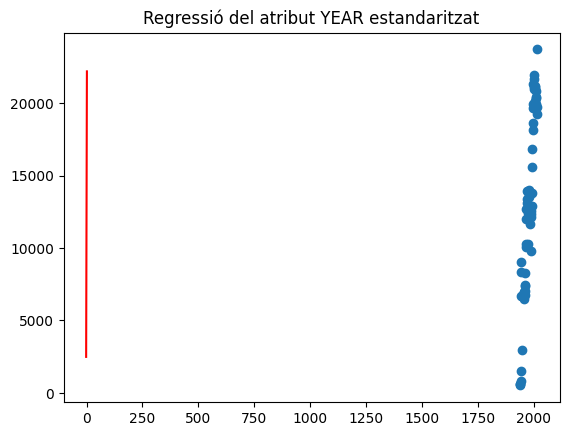

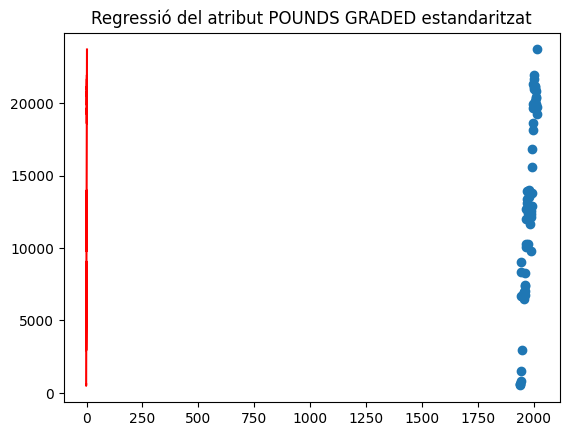

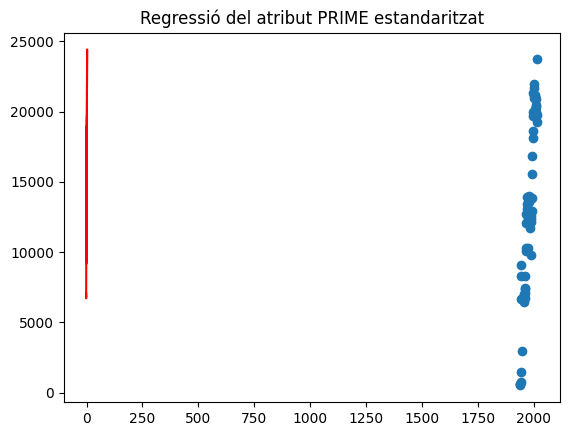

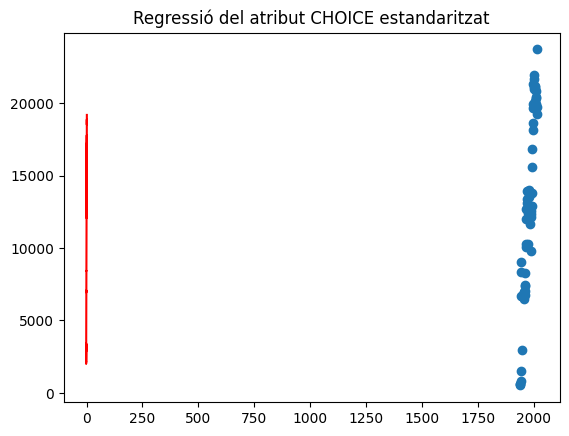

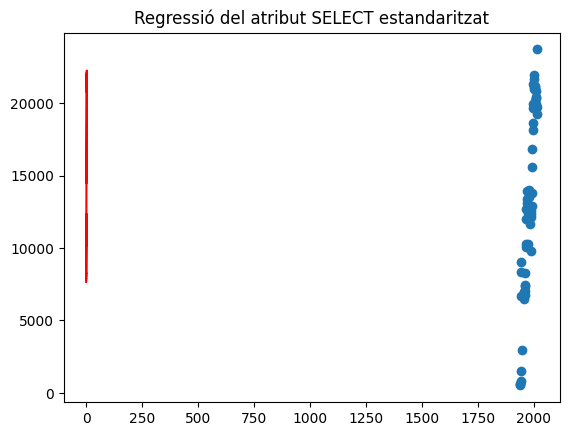

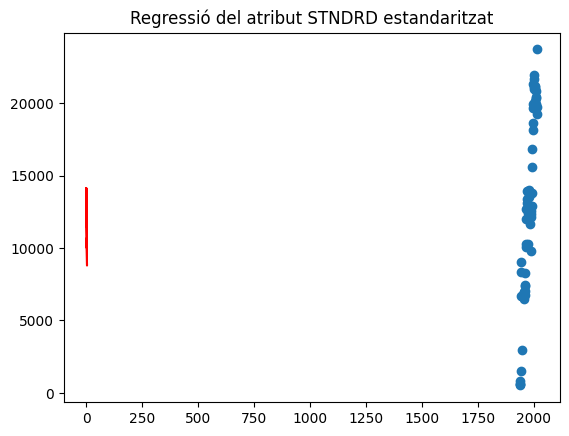

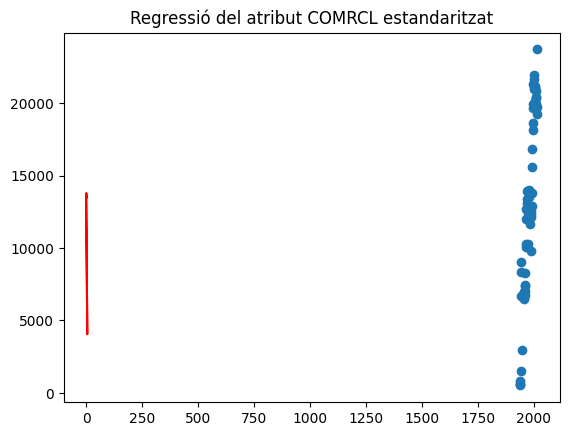

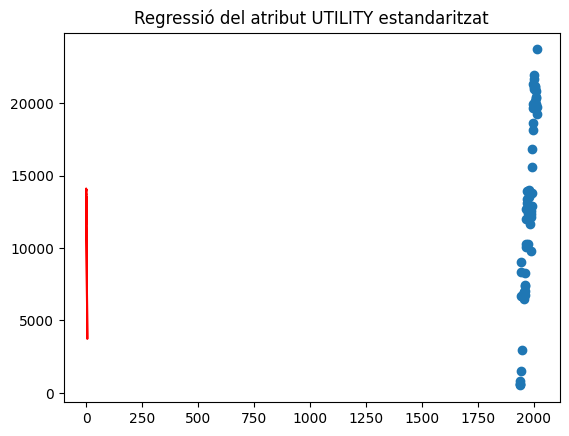

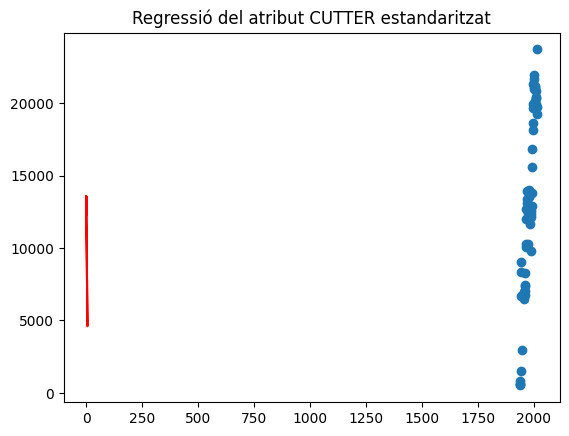

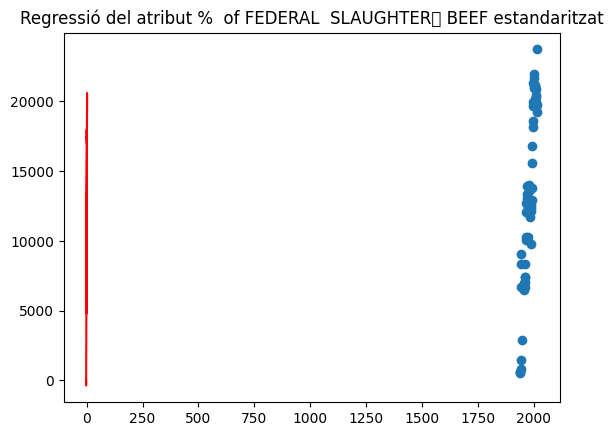

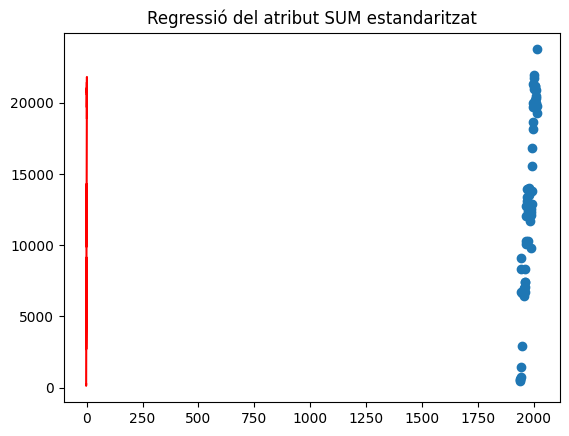

In [45]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
for index2 in range(xFill0.shape[1]):
    index1 = index2
    atribut1 = xFill0[:,index1].reshape(xFill0.shape[0], 1) 
    atribut1 = standarize(atribut1)
    regr = regression(atribut1, yFill0) 
    predicted = regr.predict(atribut1)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {} estandaritzat".format(index[index1]))
    ax = plt.scatter(xFill0[:,0], yFill0)
    plt.plot(atribut1[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(yFill0, predicted)
    r2 = r2_score(yFill0, predicted)

    print("Mean squeared error ",index[index1],": ", MSE)
    print("R2 score: ", r2)

Un cop mostrats de manera adient, (en forma de taula, i/o de gràfics si la dimensionalitat ho permet) els resultats aconseguits amb la regressió, avaluarem de manera independent la idonietat de cadascun dels atributs.

Error en atribut 0: 4148387.721749
R2 score en atribut 0: 0.887778
Error en atribut 1: 0.000000
R2 score en atribut 1: 1.000000
Error en atribut 2: 25523450.818595
R2 score en atribut 2: 0.309539
Error en atribut 3: 10426801.749981
R2 score en atribut 3: 0.717934
Error en atribut 4: 14883426.677635
R2 score en atribut 4: 0.597373
Error en atribut 5: 15258152.878079
R2 score en atribut 5: 0.587236
Error en atribut 6: 36862943.336439
R2 score en atribut 6: 0.002783
Error en atribut 7: 36027675.856693
R2 score en atribut 7: 0.025378
Error en atribut 8: 38506133.886593
R2 score en atribut 8: -0.041669
Error en atribut 9: 12927880.365265
R2 score en atribut 9: 0.650275
Error en atribut 10: 1336214.811858
R2 score en atribut 10: 0.963853


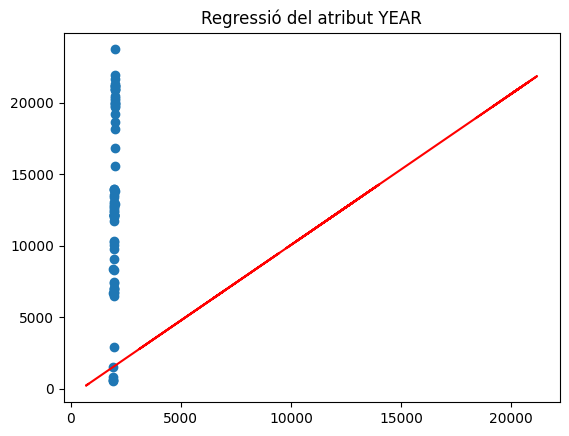

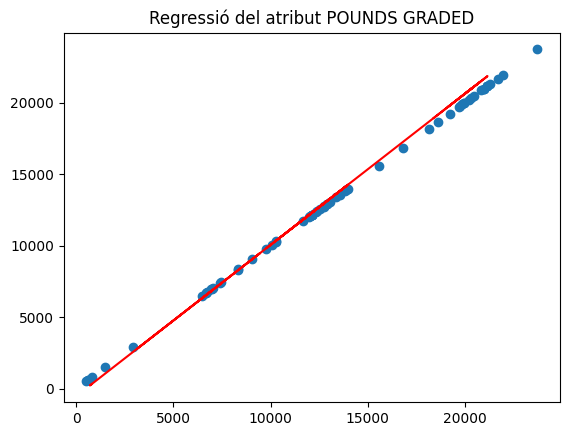

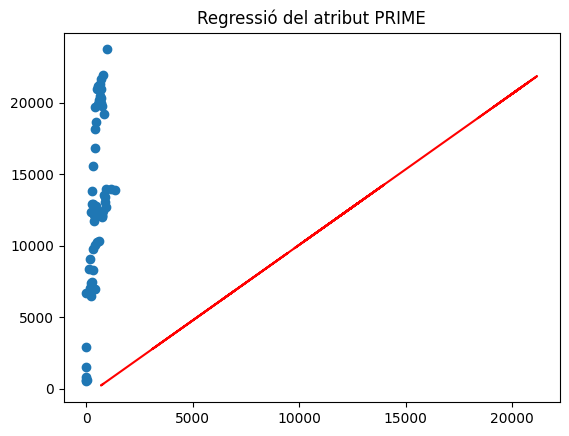

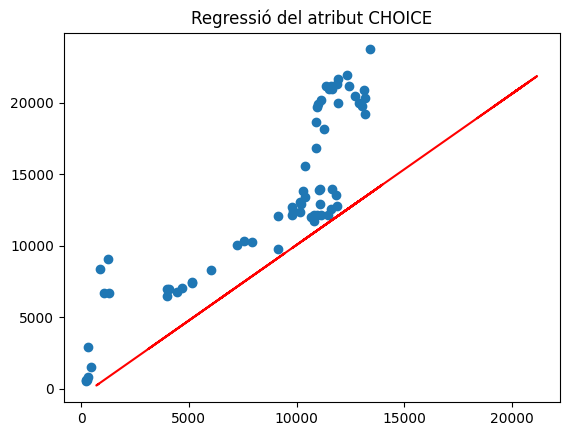

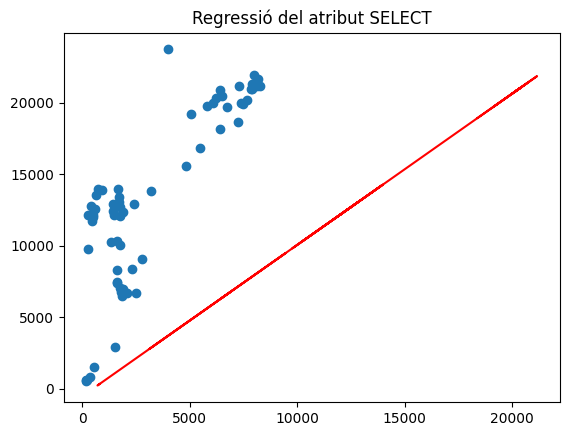

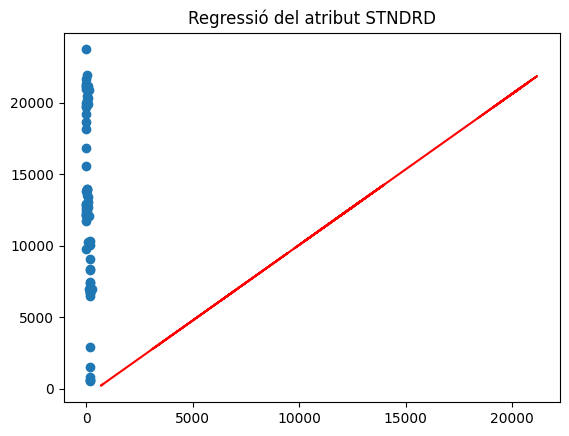

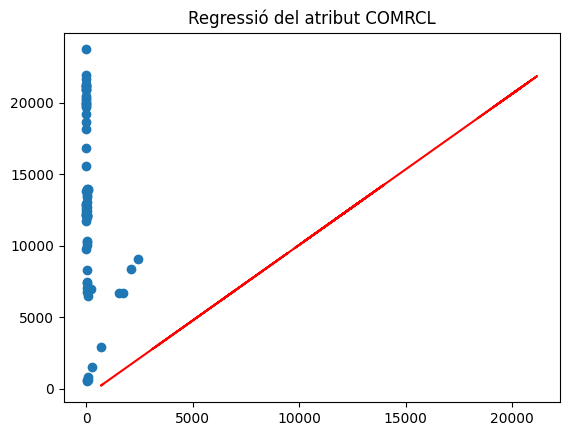

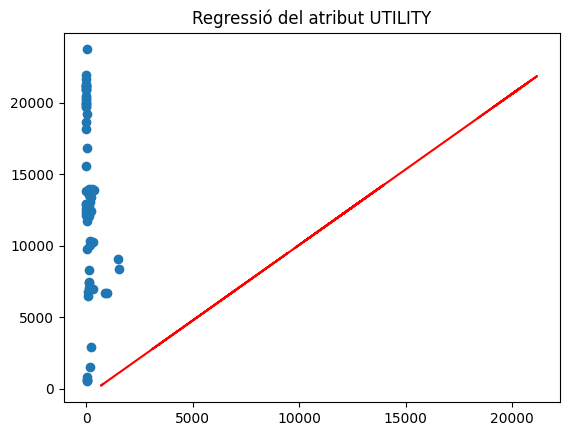

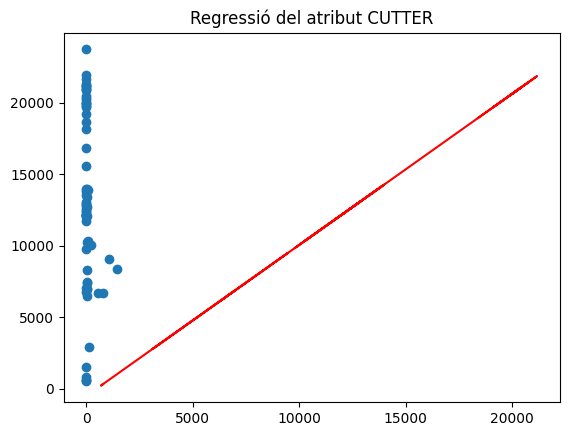

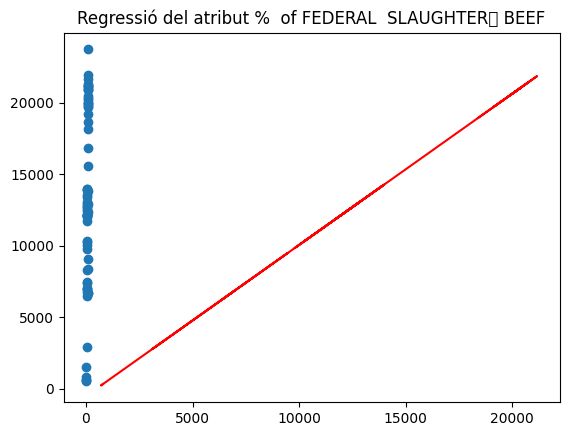

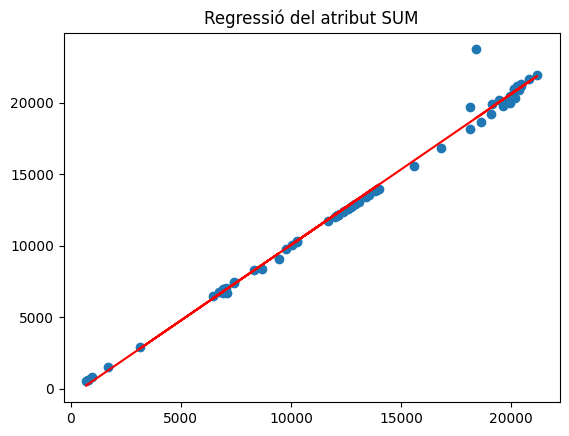

In [48]:
""" Per a assegurar-nos que el model s'ajusta be a dades noves, no vistes, 
cal evaluar-lo en un conjunt de validacio (i un altre de test en situacions reals).
Com que en aquest cas no en tenim, el generarem separant les dades en 
un 80% d'entrenament i un 20% de validació.
"""
def split_data(x, y, train_ratio=0.7):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x, y)

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)    
    error = mse(y_val, regr.predict(x_v)) # calculem error
    r2 = r2_score(y_val, regr.predict(x_v))
    
    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {}".format(index[i]))
    ax = plt.scatter(x[:,i], y)
    plt.plot(atr[:,0], predicted, 'r')

    print("Error en atribut %d: %f" %(i, error))
    print("R2 score en atribut %d: %f" %(i, r2))


Així es podrà contestar a aquestes **preguntes**:

1. Quin són els atributs més importants per fer una bona predicció?

2. Amb quin atribut s'assoleix un MSE menor?

3. Quina correlació hi ha entre els atributs de la vostra base de dades?

4. Com influeix la normalització en la regressió?

5. Com millora la regressió quan es filtren aquells atributs de les mostres que no contenen informació?

6. Si s'aplica un PCA, a quants components es redueix l'espai? Per què?


# Apartat (A): El descens del gradient  

En aquest exercici, es tracta d'implementar en python el procés de descent del gradient explicat a les classes de teoria, i comparar-lo amb els resultats obtinguts amb l'apartat (B). 

$$J(w) = \frac{1}{2m} \left[ \sum^m_{i=1}(f(x^{i}; w) - y^{i})^2 + \lambda\sum_{j=1}^{n}(w_{j}^2) \right]$$

Fixeu-vos que $J$ retorna el `mse`. Per a trobar $w_j$, repetir fins convergència:
$$w_0 = w_0 - \alpha \frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot 1$$
$$w_j = w_j - \alpha \left[\frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i} - \frac{\lambda}{m}w_{j} \right]$$


ó:

$$w_{j} := w_{j} \left(1-\alpha \frac{\lambda}{m} \right) - \alpha\frac{\lambda}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i}$$

On si considerem un regressor lineal (el model és una recta), llavors $w_0$ i $w_1$ representen, respectivament, la $b$ i $a$ de la fòrmula de la recta: 

$$h_\theta(x^{(i)}) = ax + b$$

$\alpha$ és el learning rate, i $h_\theta(x^{(i)})$ és la funció que fa la regressió, és a dir, la funció que prediu el valor de $y^{(i)}$ donat un(s) atribut(s) concret(s) $x^{(i)}$.

Així, tenint calculat el model en l'últim punt del primer exercici, ja sabeu quin resultat hauríeu d'obtenir. O no, perquè la vostra implementació pot ser millor! En concret, es tracta de desenvolupar aquestes tasques:

* Definir la funció de cost i del gradient

* Estudiar com l'ús de regularitzadors afecta el resultat: overfitting, underfitting, etc. 

* Visualització de les dades a analitzar i explicació pas a pas del procediment   

* Visualització del procés de descens de gradient 

* Modificar el learning rate i el nombre d'iteracions 

<img src="images/gradient_descent.png">

Per a la implementació us podeu basar en el següent esquelet:

In [49]:
class Regressor(object):
    def __init__(self, w0, w1, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.alpha = alpha

        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        pass
    
    def __update(self, hy, y):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        pass
    
    def train(self, max_iter, epsilon):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        pass

L'últim pas serà validar el regressor trobat pel descent del gradient desenvolupat en aquest apartat visualment, aplicat a un model de recta i un model de pla. Per a això, caldrà considerar el millor atribut identificat en el primer punt de l'anterior entrega per visualitzar la línia regressora en 2D (podeu mostrar dades 2d amb la funció scatter). Després, dos dels atributs identificats a l'últim punt del primer exercici per visualitzar el pla regressor en 3D (En el cas 3D l’scatter s’ha de fer sobre una figura amb projecció 3D).

<IPython.core.display.Javascript object>


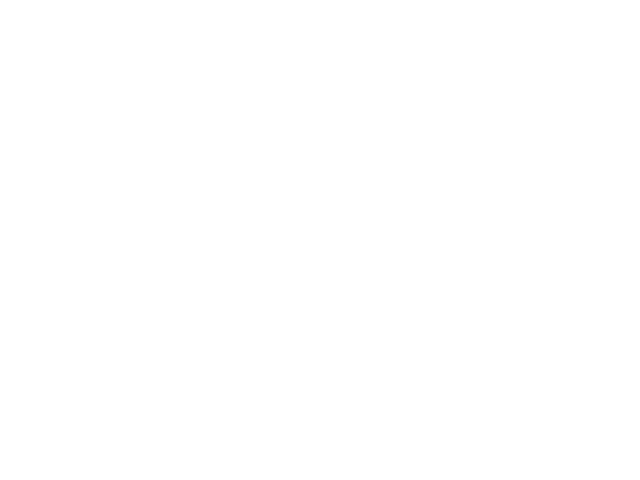

TypeError: gca() got an unexpected keyword argument 'projection'

In [50]:
%matplotlib notebook

# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple
x_val = np.random.random((100, 2))
y_val = np.random.random((100, 1))
regr = regression(x_val, y_val)
predX3D = regr.predict(x_val)

# Afegim els 1's
A = np.hstack((x_val,np.ones([x_val.shape[0],1])))
w = np.linalg.lstsq(A,predX3D)[0]

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 =  malla * (max(x_val[:,0]) - min(x_val[:,0]))/2 + min(x_val[:,0])
malla_x2 =  malla * (max(x_val[:,1]) - min(x_val[:,1]))/2 + min(x_val[:,1])

#la funcio meshgrid ens aparella un de malla_x1 amb un de malla_x2, per atot
#element de mallax_1 i per a tot element de malla_x2.
xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)

# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean

#ara creem la superficies que es un pla
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot,yplot,zplot, color='red')
plt3d.scatter(x_val[:,0],x_val[:,1],y_val)

Així es podrà contestar a aquestes preguntes:

1. Com influeixen tots els paràmetres en el procés de descens? Quins valors de learning rate convergeixen més ràpid a la solució òptima? Com influeix la inicialització del model en el resultat final? 

2. Quines funcions polinomials (de diferent grau, de diferents combinacions d'atributs, ...) heu escollit per ser apreses amb el vostre descens del gradient? quina ha donat el millor resultat (en error i rapidesa en convergència)?

3. Utilitzeu el regularitzador en la fòrmula de funció de cost i descens del gradient i proveu polinomis de diferent grau. Com afecta el valor del regularitzador?

3. Quina diferència (quantitativa i qualitativa) hi ha entre el vostre regressor i el de la llibreria ?

4. Té sentit el model (polinomial) trobat quan es visualitza sobre les dades? 

5. Ajuda la visualització a identificar aquelles mostres per a les que el regressor obté els pitjors resultats de predicció? 
